# Foreign Exchange Intervention Rules for Central Banks: A Risk-Based Framework

This notebook replicates the tables and the charts of the IMF WP on Foreign Exchange Intervention Rules for Central Banks: A Ris-Based Framework

It uses a Python package that I have written, DistGARCH, also available in this Github folder, with the public FX intervention data from the Banco Mexico. DistGARCH is based on the ARCH package of Kevin Sheppard.

You can use the code for non-commercial applications, providing that you cite the  IMF Working Paper\
Lafarguette, R. and Veyrune, R. (2021) *Foreign Exchange Intervention Rules for Central Banks: A Ris-Based Framework*,
IMF Working Paper no 2021032 https://www.imf.org/en/Publications/WP/Issues/2021/02/12/Foreign-Exchange-Intervention-Rules-for-Central-Banks-A-Risk-based-Framework-50081

Author: Romain Lafarguette, June 2021
If you have any question, please contact me via Github or rlafarguette "at" imf "dot" org

## Preamble

In [1]:
# System paths
import os, sys

# Global modules
import importlib                                        # Operating system
import pandas as pd                                     # Dataframes
import numpy as np                                      # Numeric Python
import datetime                                         # Dates
import arch                                             # ARCH/GARCH models

# Functional imports
from datetime import datetime as date                   # Short date function
from dateutil.relativedelta import relativedelta        # Dates manipulation 

# ARCH package functional imports
from arch.univariate import (ARCH, GARCH, EGARCH, EWMAVariance, # Vol process
                             FixedVariance, RiskMetrics2006) 
from arch.univariate import (Normal, StudentsT, # Distribution of residuals
                             SkewStudent, GeneralizedError)

# Local modules
from varfxi.quantileproj import QuantileProj
from varfxi.distGARCH import DistGARCH

# Graphics
import matplotlib.pyplot as plt                         # Graphical package  
import seaborn as sns                                   # Graphical tools

# Graphics options
plt.rcParams["figure.figsize"] = 25,15
#plt.rcParams["figure.dpi"] = 600
sns.set(style='white', font_scale=4, palette='deep', font='serif') 

# Pandas options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

# Warnings management
import warnings
warnings.filterwarnings("ignore")

data_folder = "./data/"
output_folder = "./output/"

In [2]:
def logret(series):
    return(np.log(series/series.shift(1)))

### Figure 1: Conditional VaR and density (diagram)

<div>
<img src="../researchpaper/img/VaR_concept.PNG" width="800"/>
</div>

In [3]:
# Read the data for Mexico
macro_p = os.path.join(data_folder, 'macro_data.csv')
dm = pd.read_csv(macro_p, parse_dates=['date'], index_col=['date'])

In [4]:
inter_p = os.path.join(data_folder, 'intervention_data.csv')
di = pd.read_csv(inter_p, parse_dates=['date'], index_col=['date'])

In [5]:
df = pd.merge(dm, di, on=['date'], how='left').sort_index().copy() # Merge
df = df[~df.index.duplicated()].copy() # Duplicated index
df.head()

mxn_usd_spot  mxn_fwd_1m  min_max_spread  bid_ask_spread  \
date                                                                   
1990-01-01        2.6835         NaN           0.000             0.0   
1990-01-02        2.6770         NaN           0.007             0.0   
1990-01-03        2.6770         NaN           0.000             0.0   
1990-01-04        2.6770         NaN           0.000             0.0   
1990-01-05        2.6770         NaN           0.000             0.0   

            mxn_interbank_1m  ...  eur_usd_spot  amount  direction  type  \
date                          ...                                          
1990-01-01               NaN  ...           NaN     NaN        NaN   NaN   
1990-01-02               NaN  ...           NaN     NaN        NaN   NaN   
1990-01-03               NaN  ...           NaN     NaN        NaN   NaN   
1990-01-04               NaN  ...           NaN     NaN        NaN   NaN   
1990-01-05               NaN  ...           NaN     NaN        NaN   NaN   

            sell_amount  
date                     
1990-01-01          NaN  
1990-01-02          NaN  
1990-01-03          NaN  
1990-01-04          NaN  
1990-01-05          NaN  

[5 rows x 15 columns]

In [6]:
# New macro variables
df['FX level'] = df['mxn_usd_spot'].copy()
df['FX log returns'] = 1e4*logret(df['mxn_usd_spot'])
df['Bid ask abs'] = np.abs(df['bid_ask_spread'])
df['Min max abs'] = np.abs(df['min_max_spread'])
df['Forward points first difference'] = df['mxn_fwd_1m'].diff(1)/1e2
df['Interbank rate vs Libor'] = (df['mxn_interbank_1m'] - df['usa_libor_1m']).diff(1)
df['VIX first diff'] = df['vix'].diff(1)
df['EURUSD log returns'] = 1e4*logret(df['eur_usd_spot'])
df['Oil prices log returns'] = 1e4*logret(df['oil_prices'])

In [7]:
# FX intervention variables
df['FX intervention in USD'] = df['sell_amount'].fillna(0)
df['fx_intervention_minprice'] = df.loc[df['type']=='min price',
                                        'sell_amount'].fillna(0)
df['fx_intervention_nominprice'] = df.loc[df['type']=='no min price',
                                          'sell_amount'].fillna(0)
df['FX intervention dummy'] = 0
df.loc[df['FX intervention in USD'] > 0, 'FX intervention dummy'] = 1
df['FX intervention dummy lag'] = df['FX intervention dummy'].shift(1)
df['Intercept'] = 1

df['FX log returns_fwd'] = df['FX log returns'].shift(-1)

clean_p = os.path.join(data_folder, 'clean_data.csv')
df.to_csv(clean_p,index=True)

## Fit the GARCH model for different specifications

In [8]:
# Prepare the list of variables
microstructure = ['Bid ask abs',
                  'Min max abs',
                  'Forward points first difference']

cip = microstructure + ['Interbank rate vs Libor']

eurusd = cip + ['EURUSD log returns']

vix = eurusd + ['VIX first diff']

baseline = vix + ['Oil prices log returns', 'FX intervention dummy lag']

# List of models
models_l = [microstructure, cip, eurusd, vix, baseline]
labels_l = ['Microstructure', 'CIP', 'Dollar move', 'Risk Appetite','Baseline']


## Baseline GARCH Model: Fit and Forecast

### Specify the model

In [9]:
dg = DistGARCH(depvar_str='FX log returns',
               data=df,
               level_str='FX level', 
               exog_l=baseline, # Defined above 
               lags_l=[1], 
               vol_model=GARCH(1,1,1),
               # ARCH(1,1), EGARCH(1,1,1), GARCH(1,1),
               # EWMAVariance(None), RiskMetrics2006(),
               dist_family=Normal(),
               # Normal(), StudentsT(), SkewStudent(), GeneralizedError()
)

### Figure 2. Mexican Peso Against US Dollar

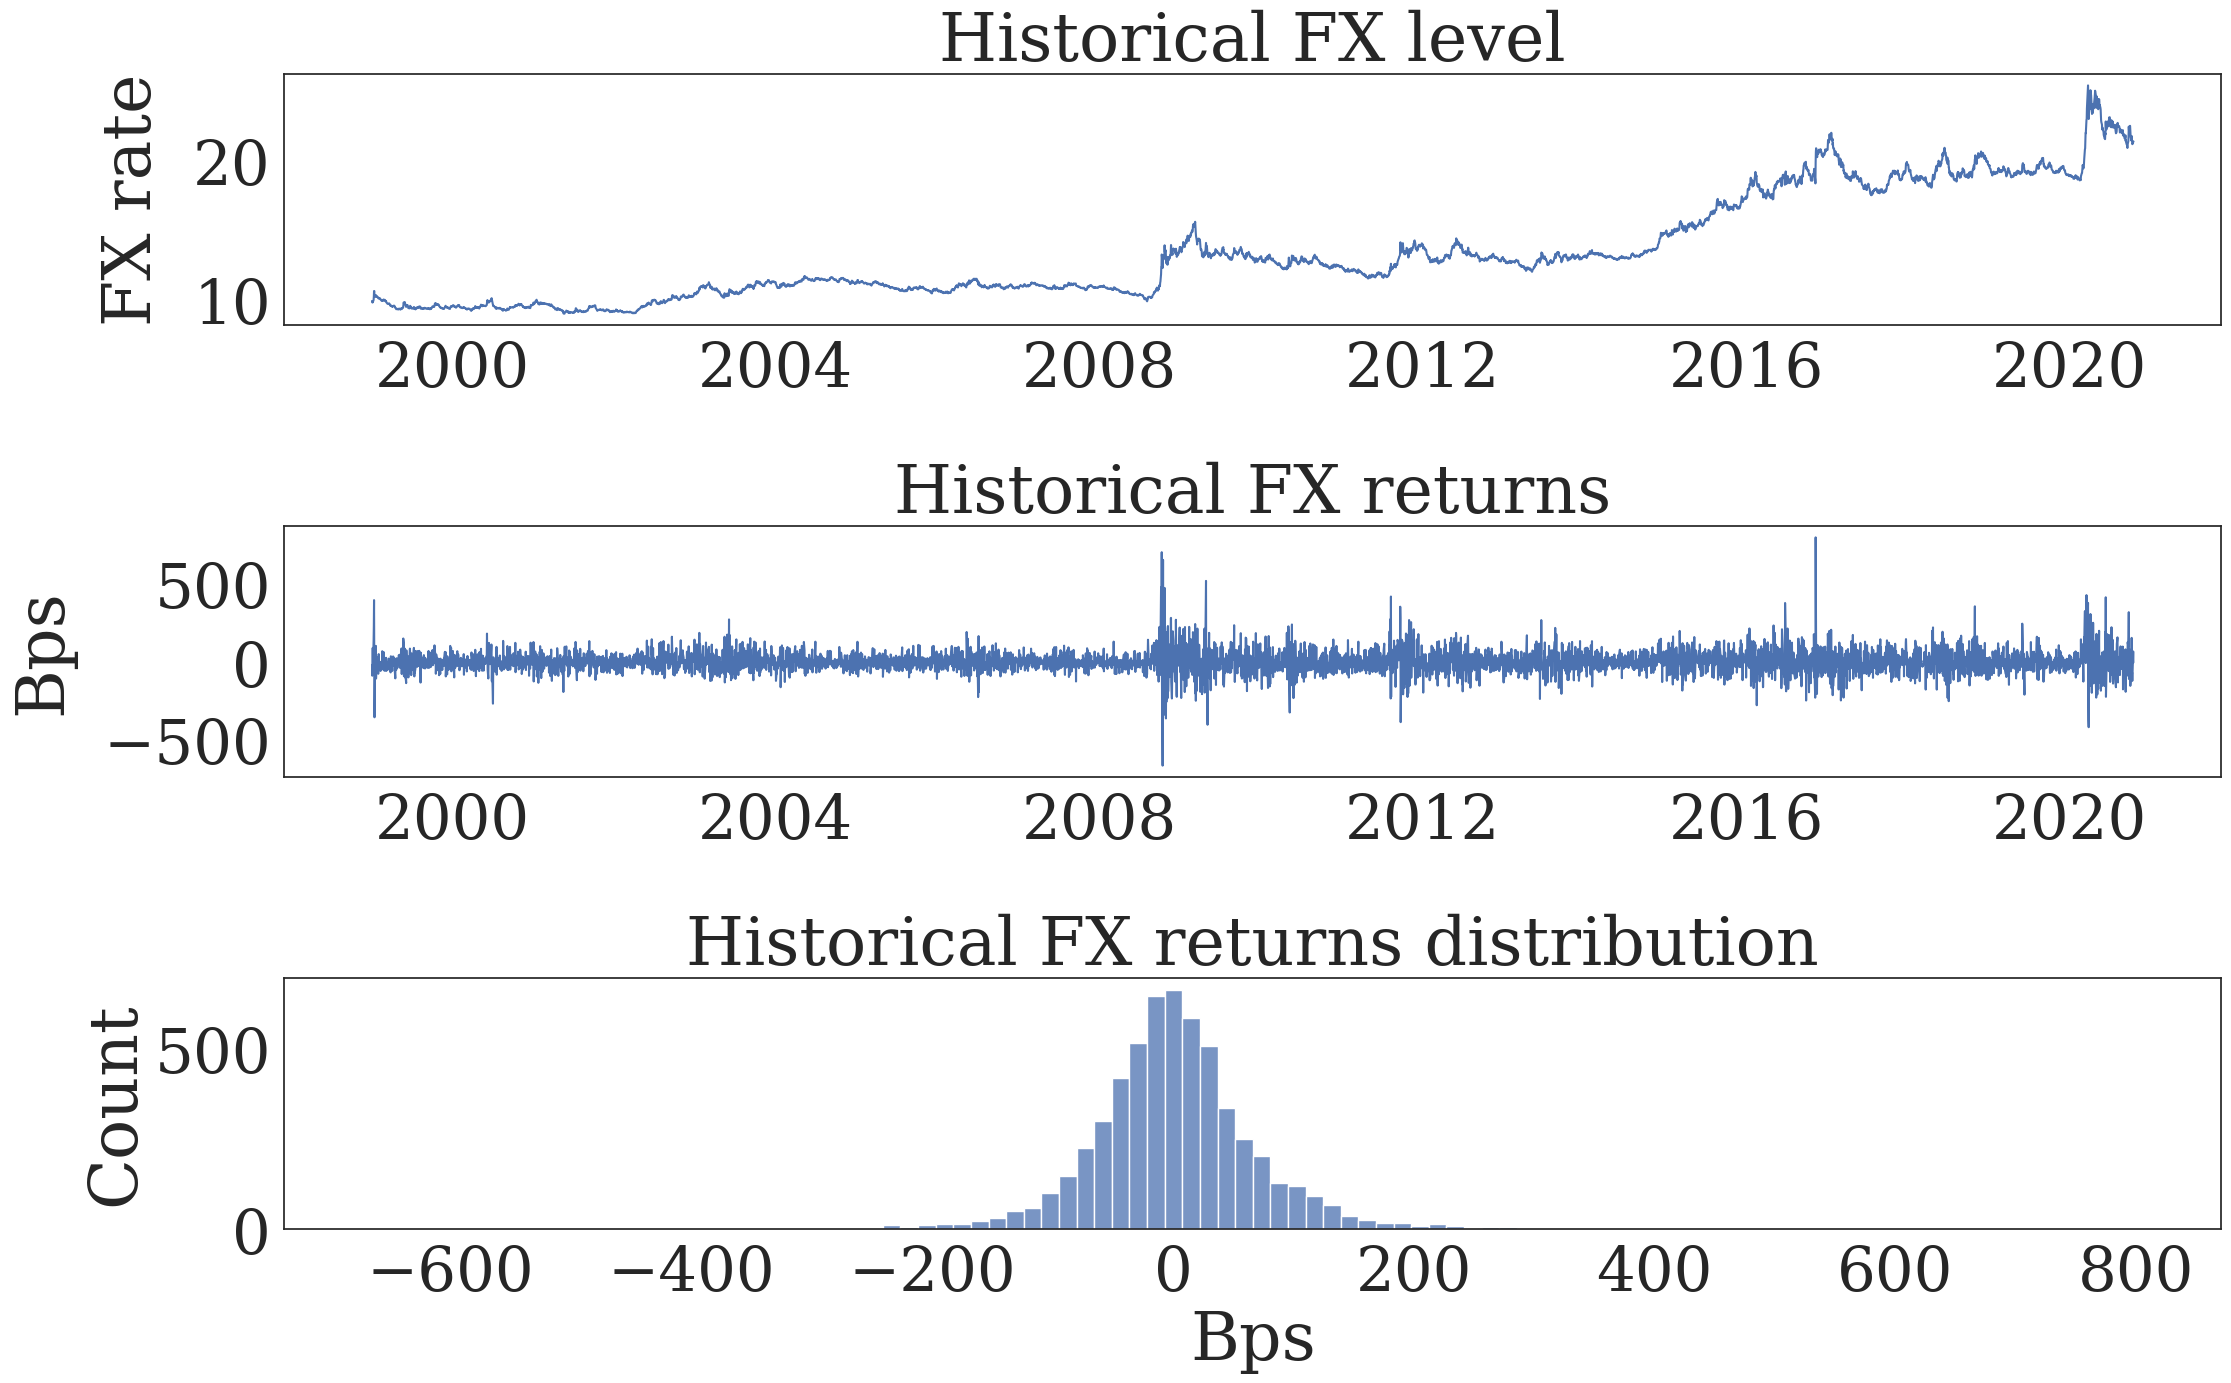

In [10]:
# Plot
dg.plot.plot_description(title_level='Historical FX level',
                    title_returns='Historical FX returns',
                    title_density='Historical FX returns distribution',
                    y_label_returns='Bps')
plt.subplots_adjust(hspace=0.8)

# Save the figure
desc_f = os.path.join(output_folder, 'descriptive_plot.pdf')
plt.savefig(desc_f, bbox_inches='tight')
plt.show()
plt.close('all')

## Fit the Model

In [11]:
# Fit the model
dgf = dg.fit()

                        AR-X - GJR-GARCH Model Results                        
Dep. Variable:         FX log returns   R-squared:                       0.279
Mean Model:                      AR-X   Adj. R-squared:                  0.277
Vol Model:                  GJR-GARCH   Log-Likelihood:               -30558.5
Distribution:                  Normal   AIC:                           61145.0
Method:            Maximum Likelihood   BIC:                           61238.0
                                        No. Observations:                 5680
Date:                Sat, Apr 15 2023   Df Residuals:                     5670
Time:                        10:13:36   Df Model:                           10
                                             Mean Model                                            
                                      coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------------------

### Figure 3. Conditional FX Volatility Over Time

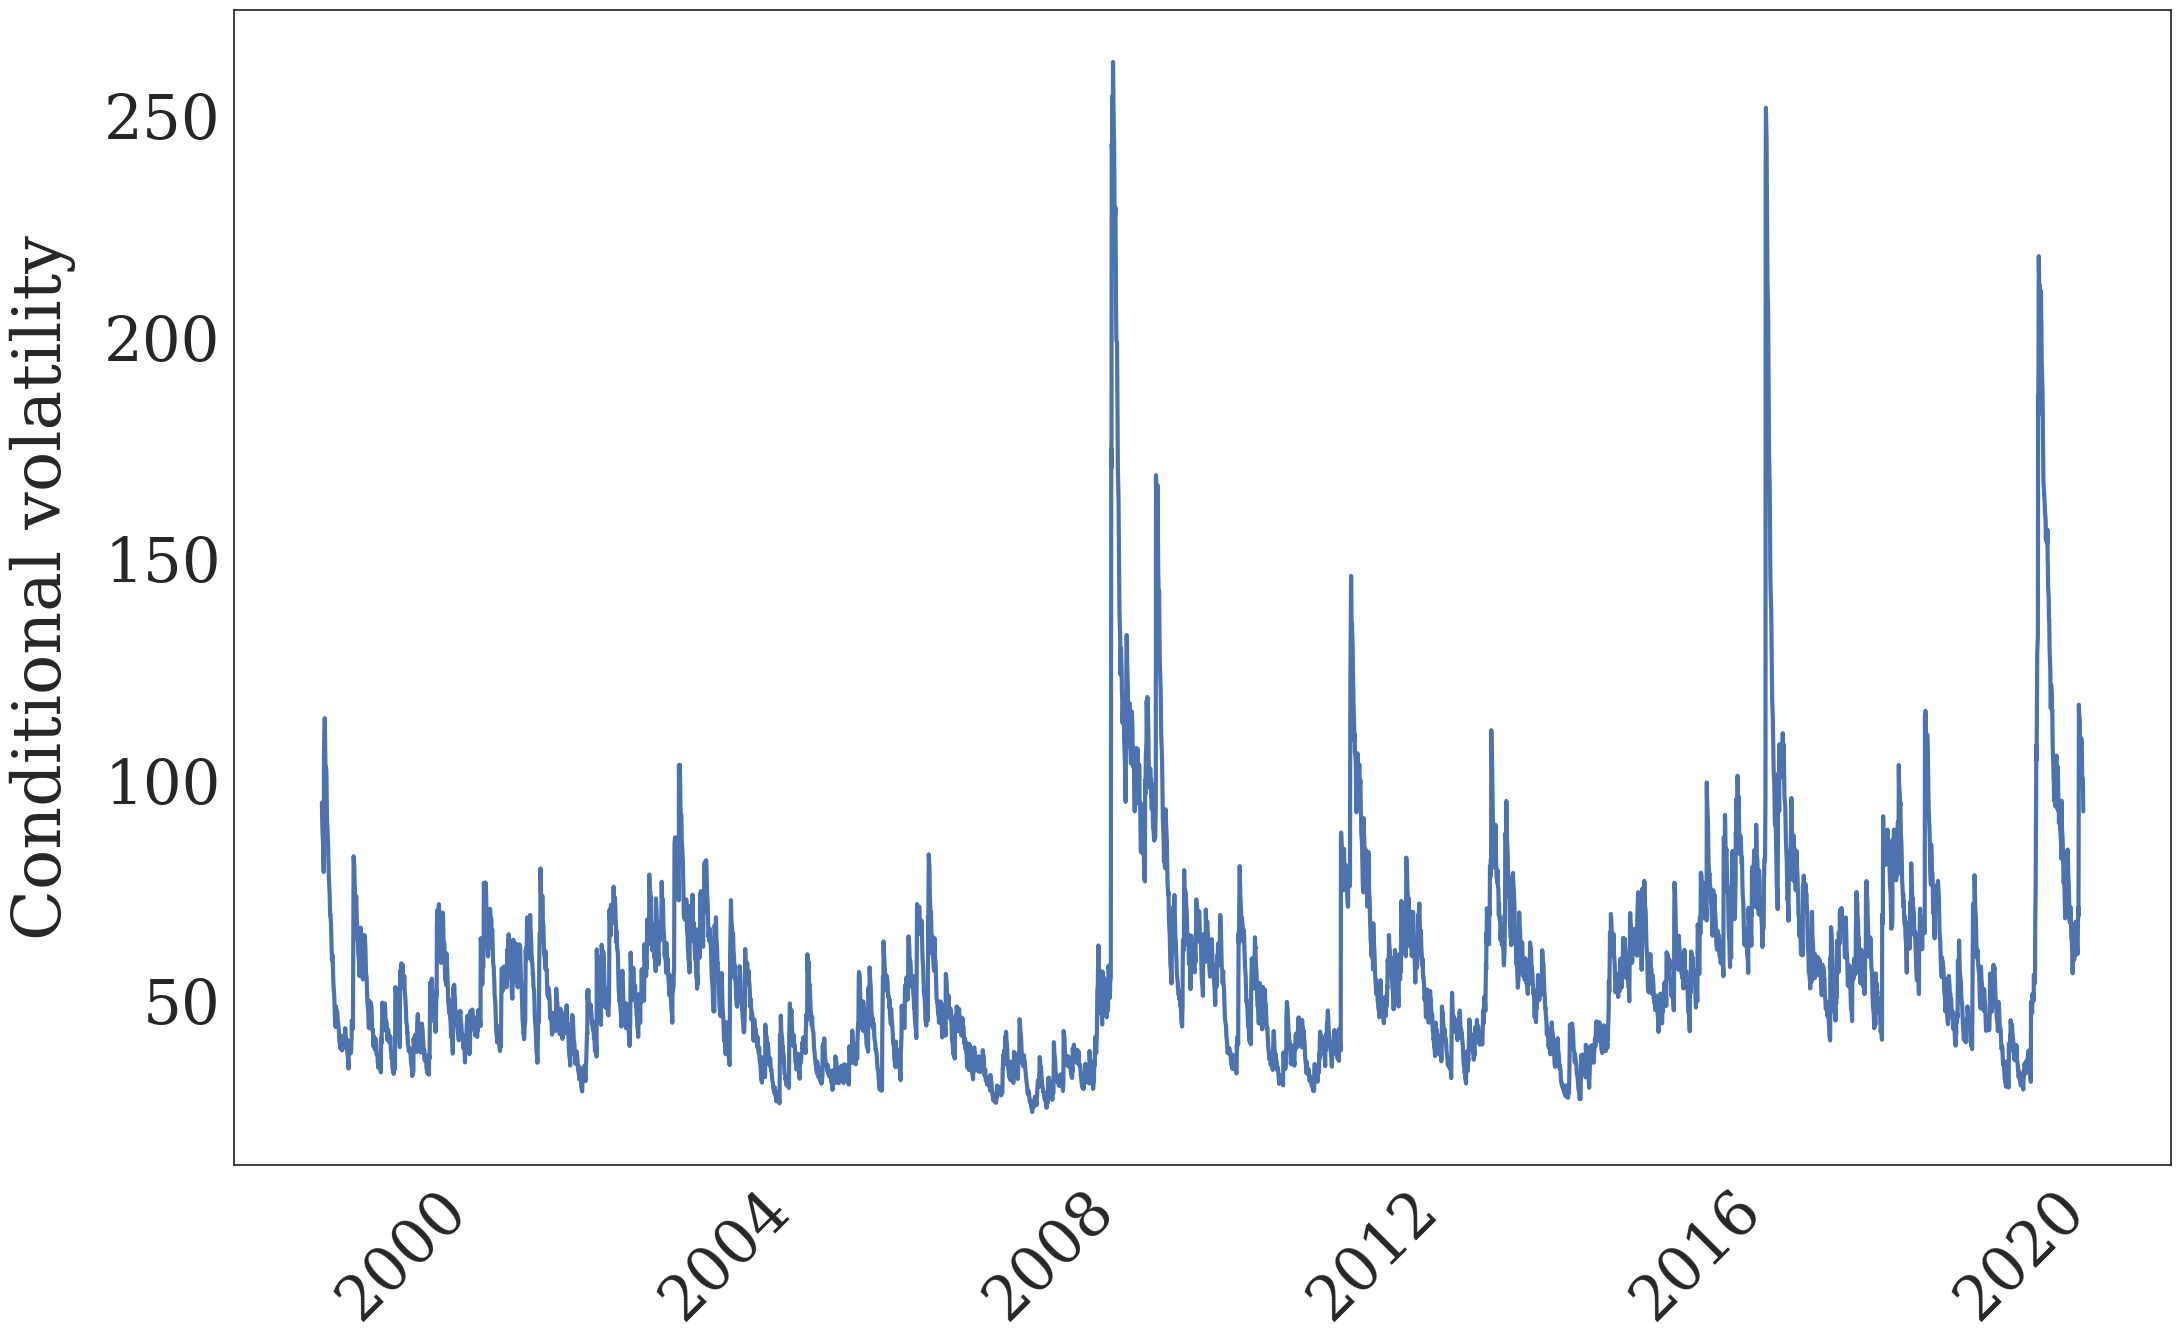

In [12]:
# Plot
dgf.plot.plot_in_cond_vol(start_date=None,
                     title='')
# Save the figure
cv_f = os.path.join(output_folder, 'conditional_vol_plot.pdf')
plt.savefig(cv_f, bbox_inches='tight')
plt.show()
plt.close('all')

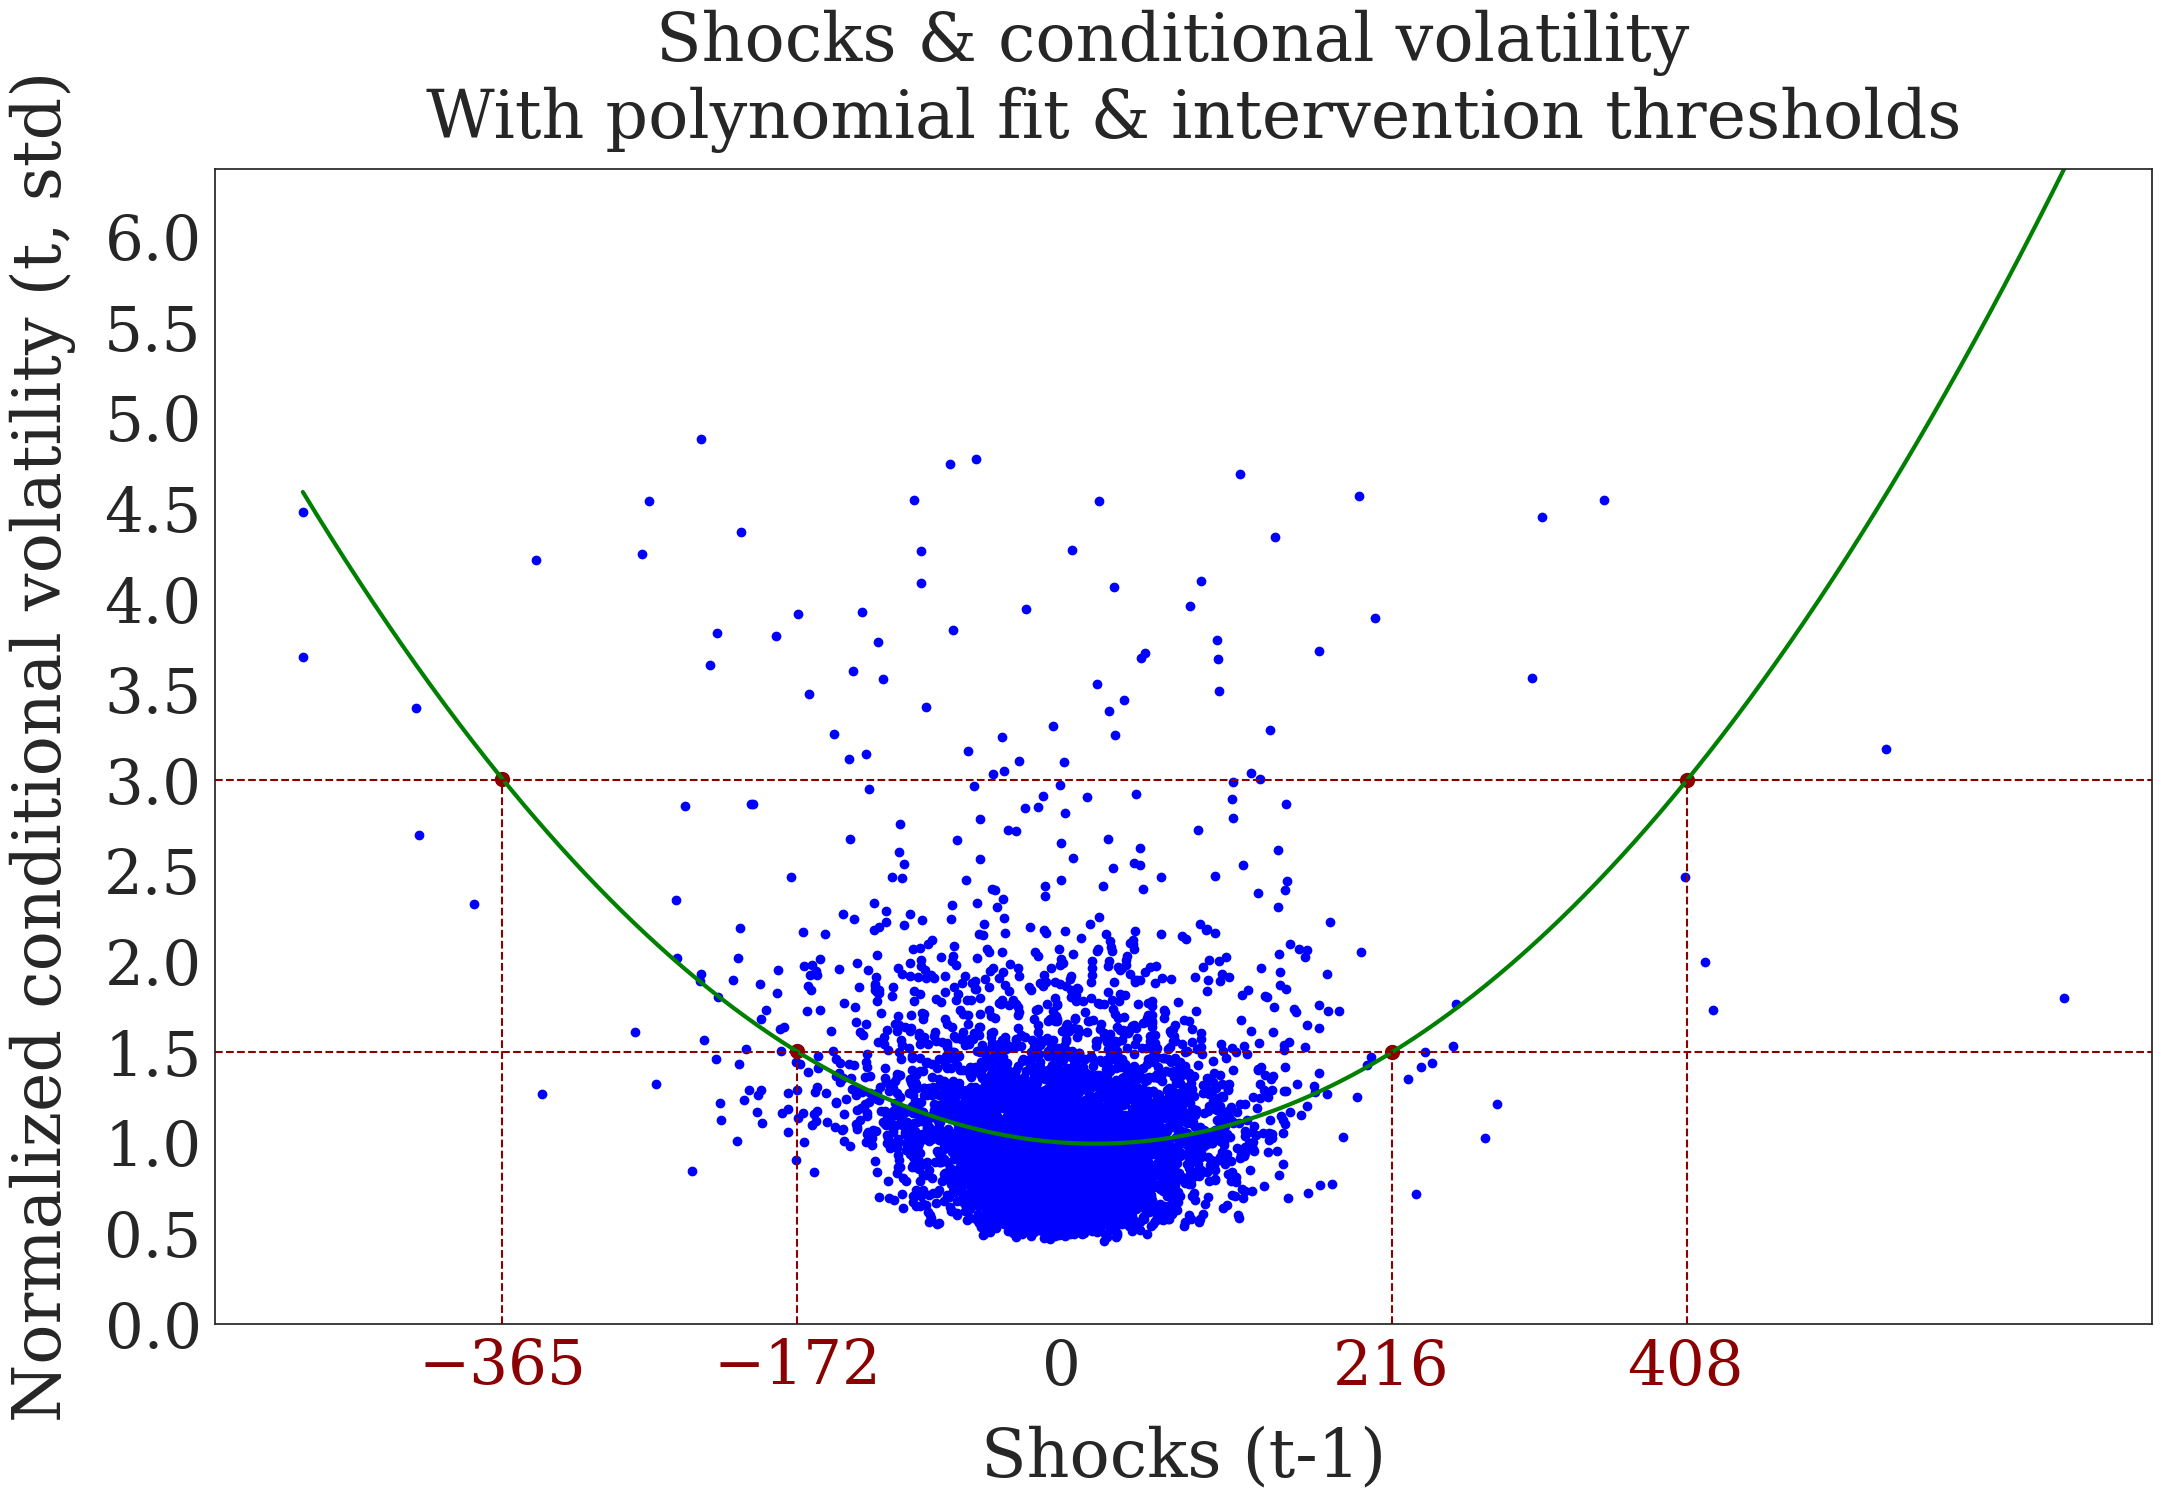

<Figure size 2500x1500 with 0 Axes>

In [13]:
# Plot
dgf.plot.plot_shocks_vol()
# Save the figure
sv_f = os.path.join(output_folder, 'shock_vol.pdf')
plt.savefig(sv_f, bbox_inches='tight')
plt.show()
plt.close('all')

### Forecast the model

In [14]:
# Forecast 2020
dgfor = dgf.forecast('2020-01-01', horizon=1)

### Figure 4. Out-of-sample Conditional Density (Joyplot)

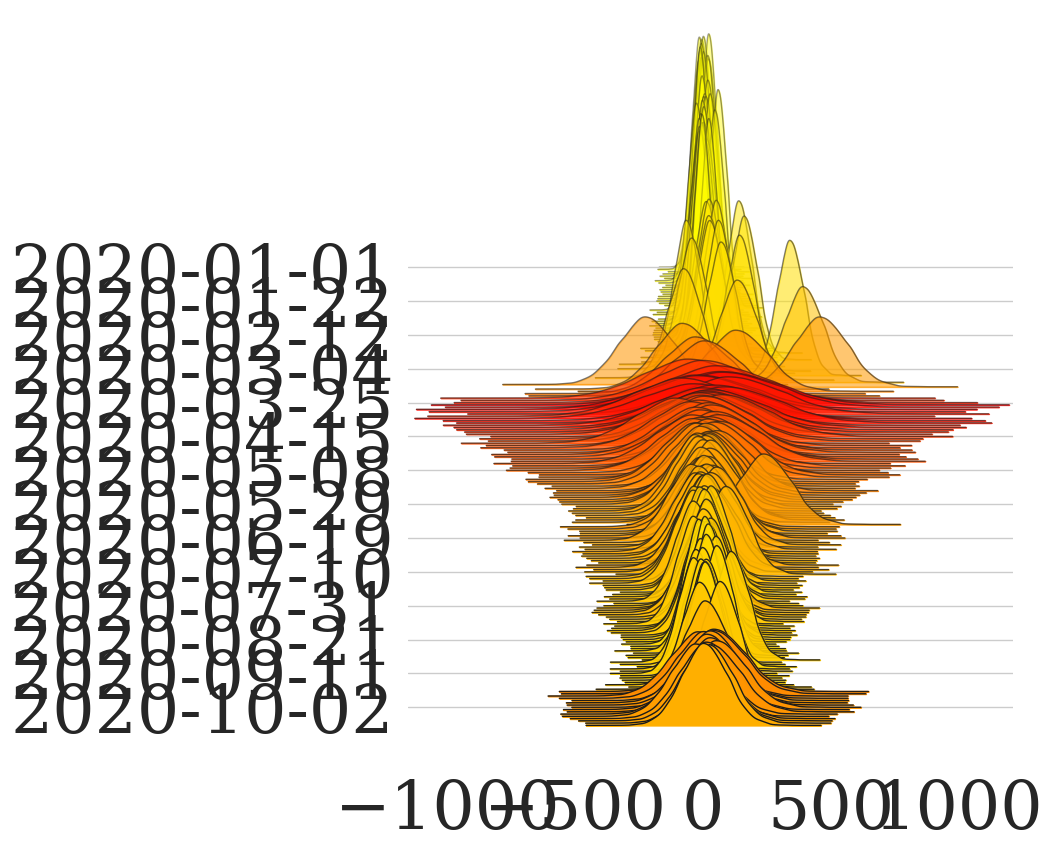

In [15]:
# Plot
dgfor.plot.plot_joyplot_out(
    title='',
    xlabel='',
    label_drop=15,
    xlimits_t=(-1000, 1000))

# Save the figure
joyplot_f = os.path.join(output_folder, 'joyplot.pdf')
plt.savefig(joyplot_f)
plt.show()
plt.close('all')


### Figure 5. Out-of-Sample Fan Chart

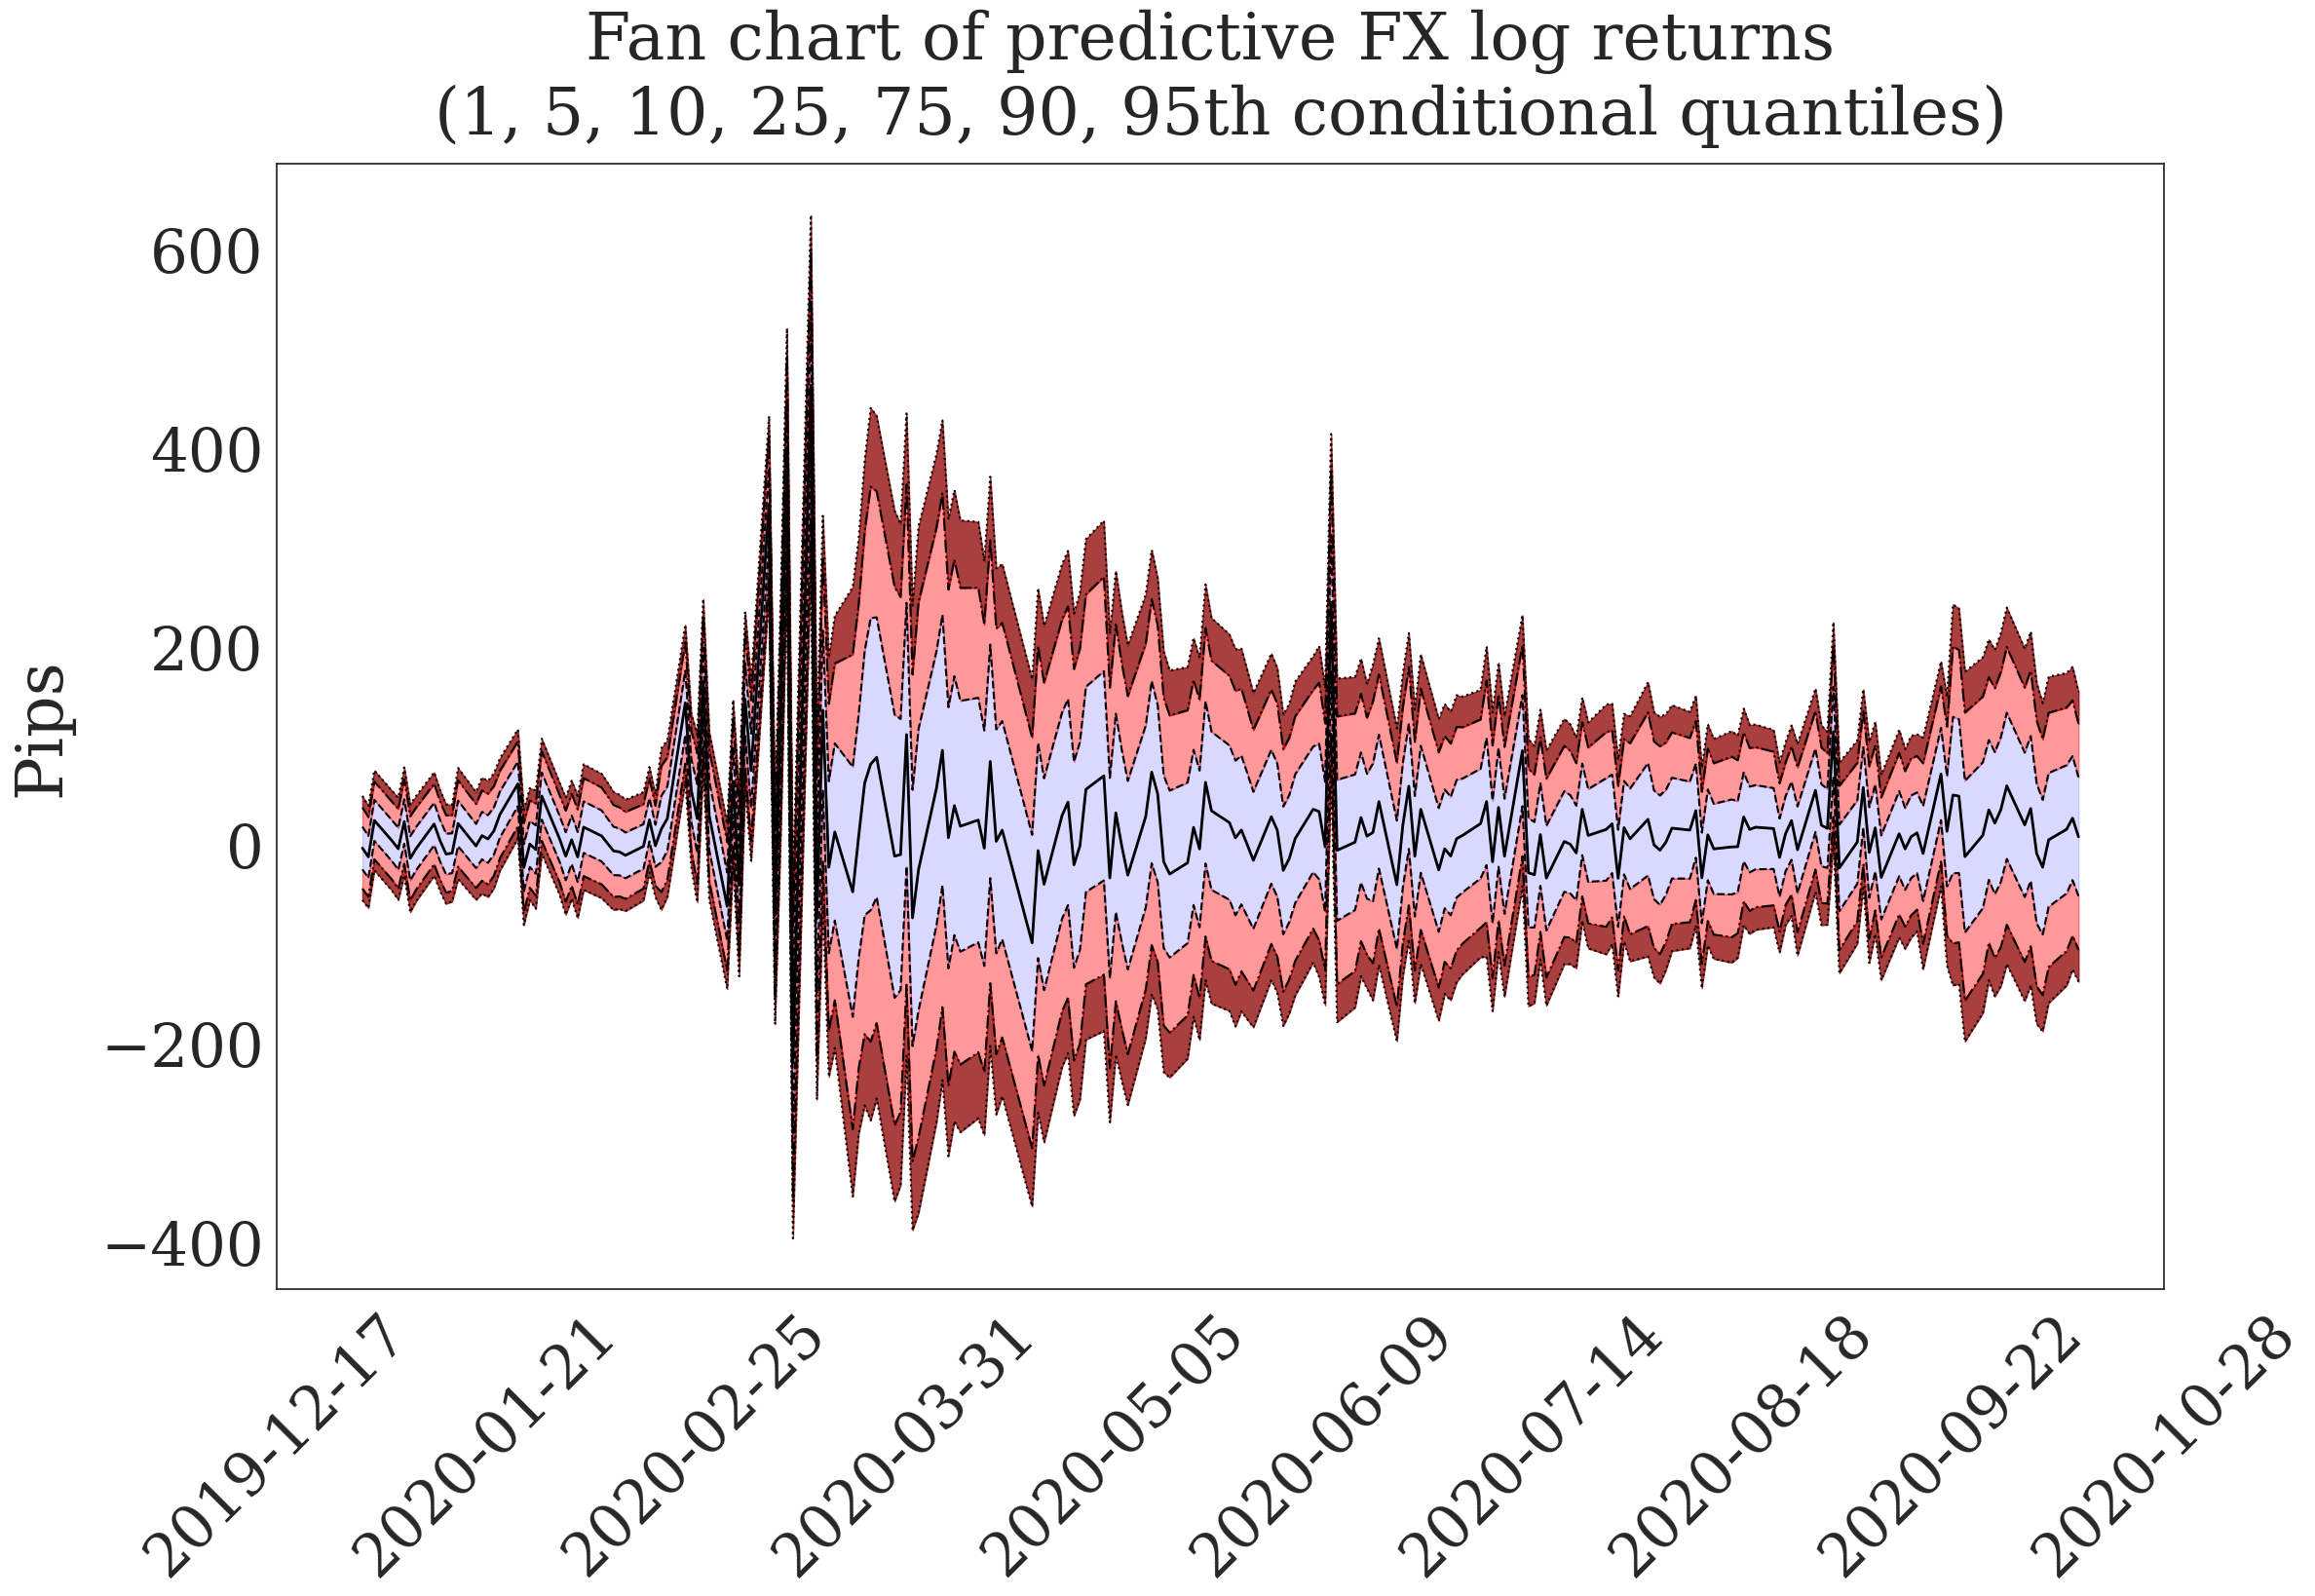

In [16]:
# Plot
dgfor.plot.plot_fan_chart(xticks_freq=35, title='Fan chart of predictive FX log returns \n'
                     '(1, 5, 10, 25, 75, 90, 95th conditional quantiles)')
plt.ylabel('Pips')

# Save the figure
fanchart_f = os.path.join(output_folder, 'fanchart.pdf')
plt.savefig(fanchart_f, bbox_inches='tight')
plt.show()
plt.close('all')

### Figure 6. Probability Integral Transform Test

In [17]:
# Plot
dgfor.plot.plot_pit()
# Save the figure
pitchart_f = os.path.join(output_folder, 'pitchart.pdf')
plt.savefig(pitchart_f, bbox_inches='tight')
plt.show 
plt.close('all')

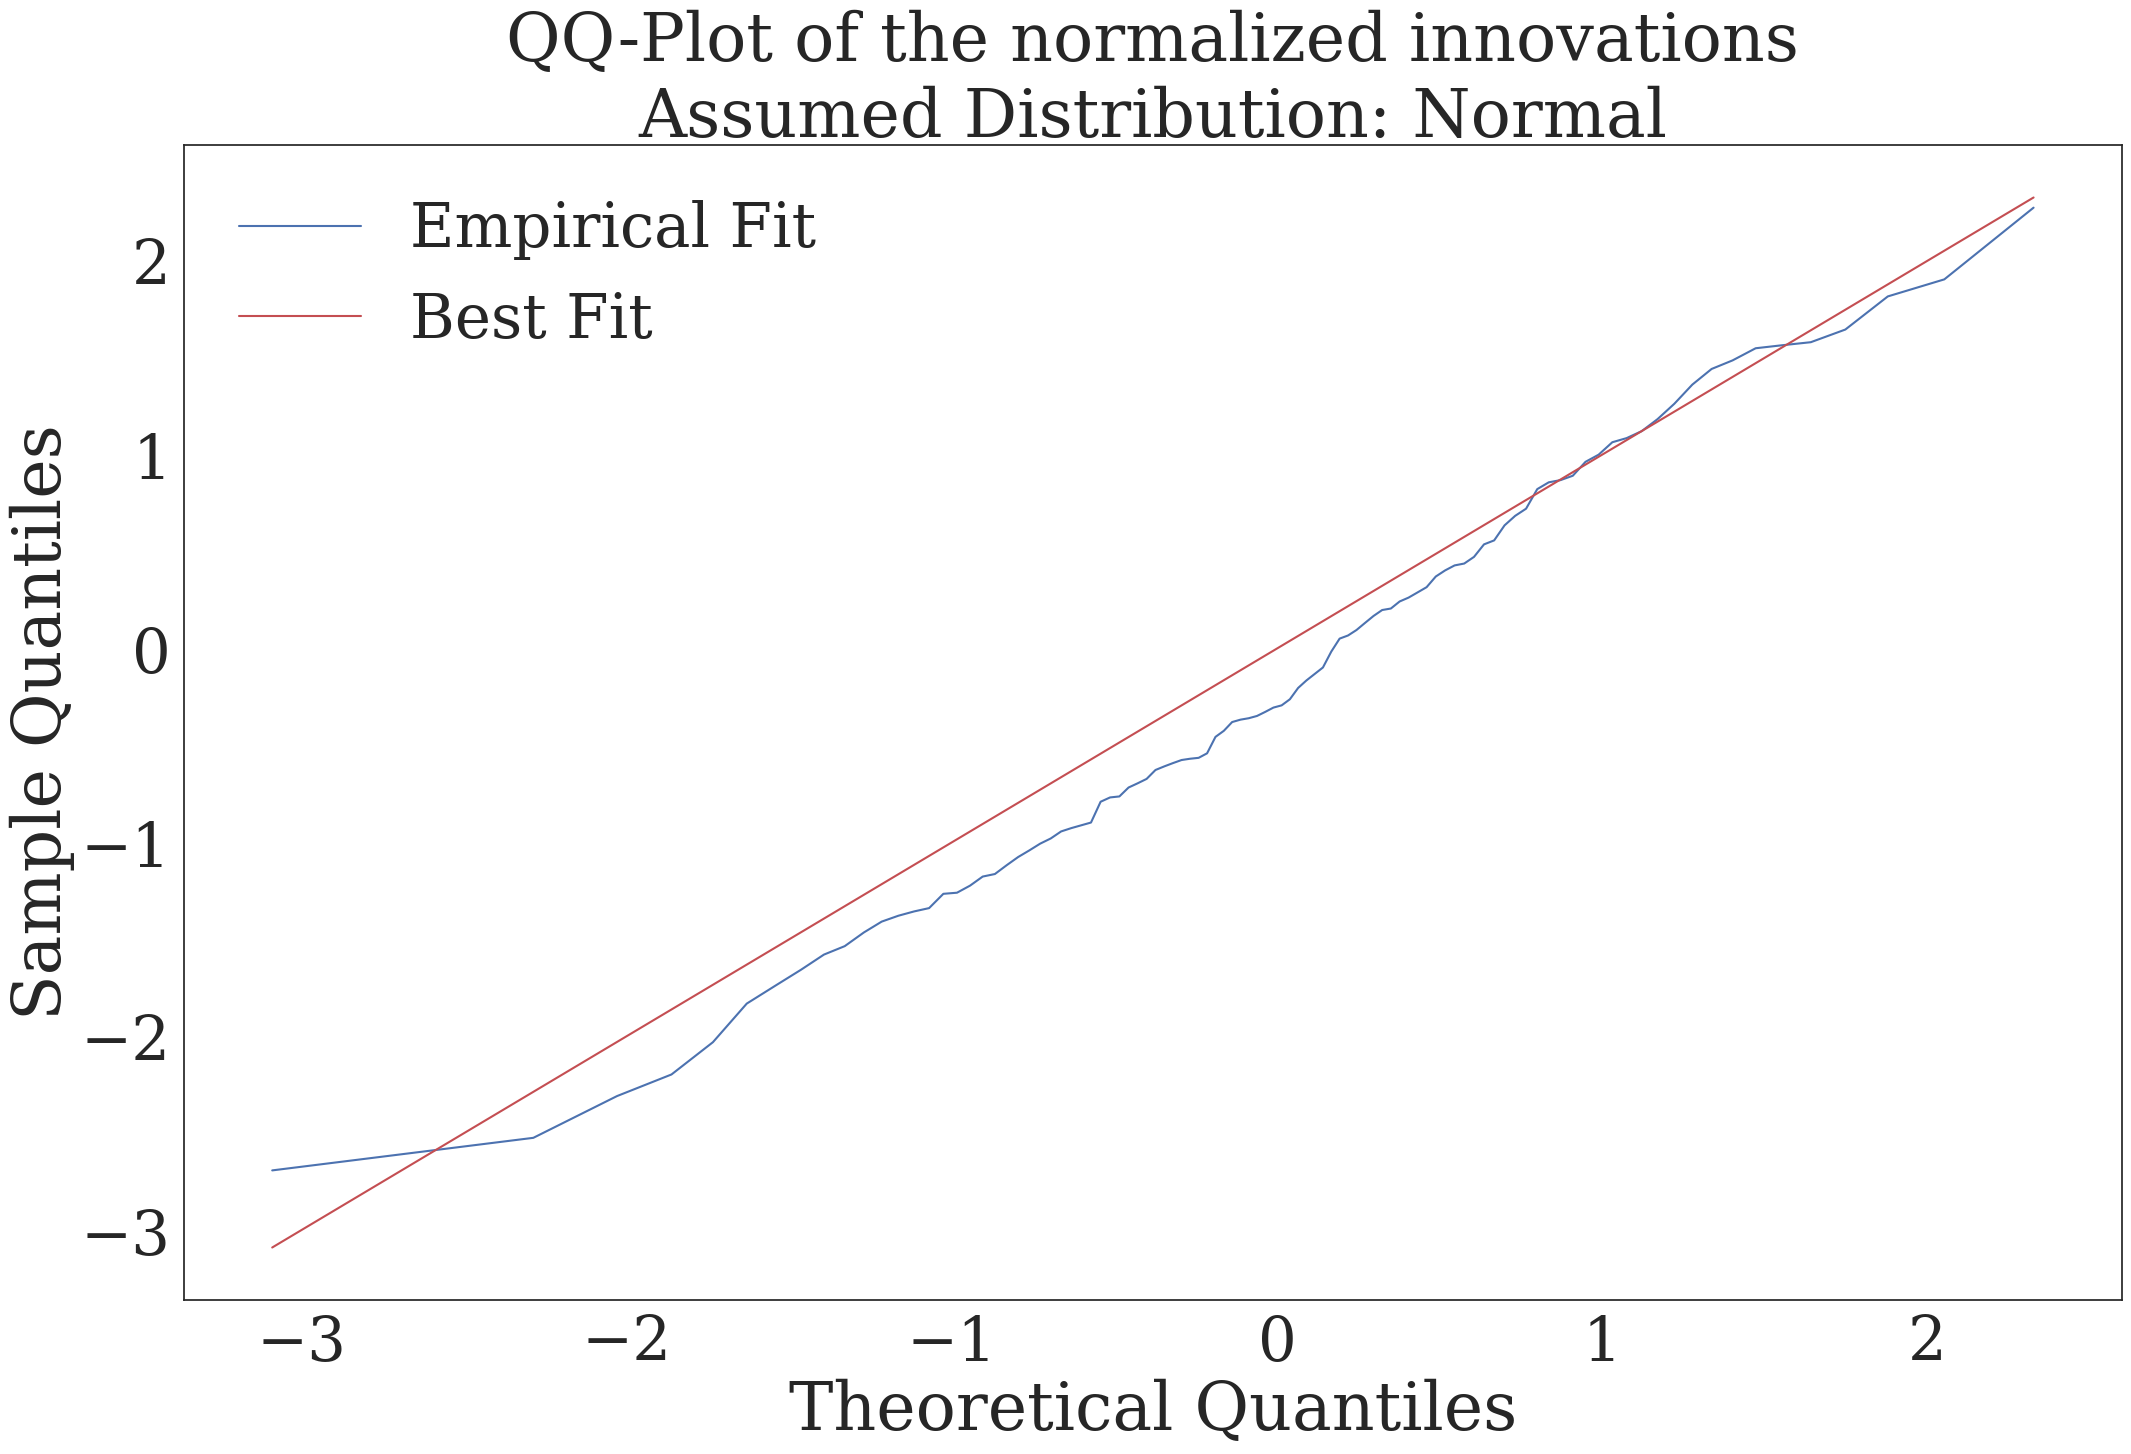

In [18]:
dgfor.plot.plot_qqplot_normalized_innovations()
# Save the figure
qqchart_f = os.path.join(output_folder, 'qqplot.pdf')
plt.savefig(pitchart_f, bbox_inches='tight')
plt.show()
plt.close('all')

### Figure 7. VaR FX Interventions Rule Based on a Given Information Set

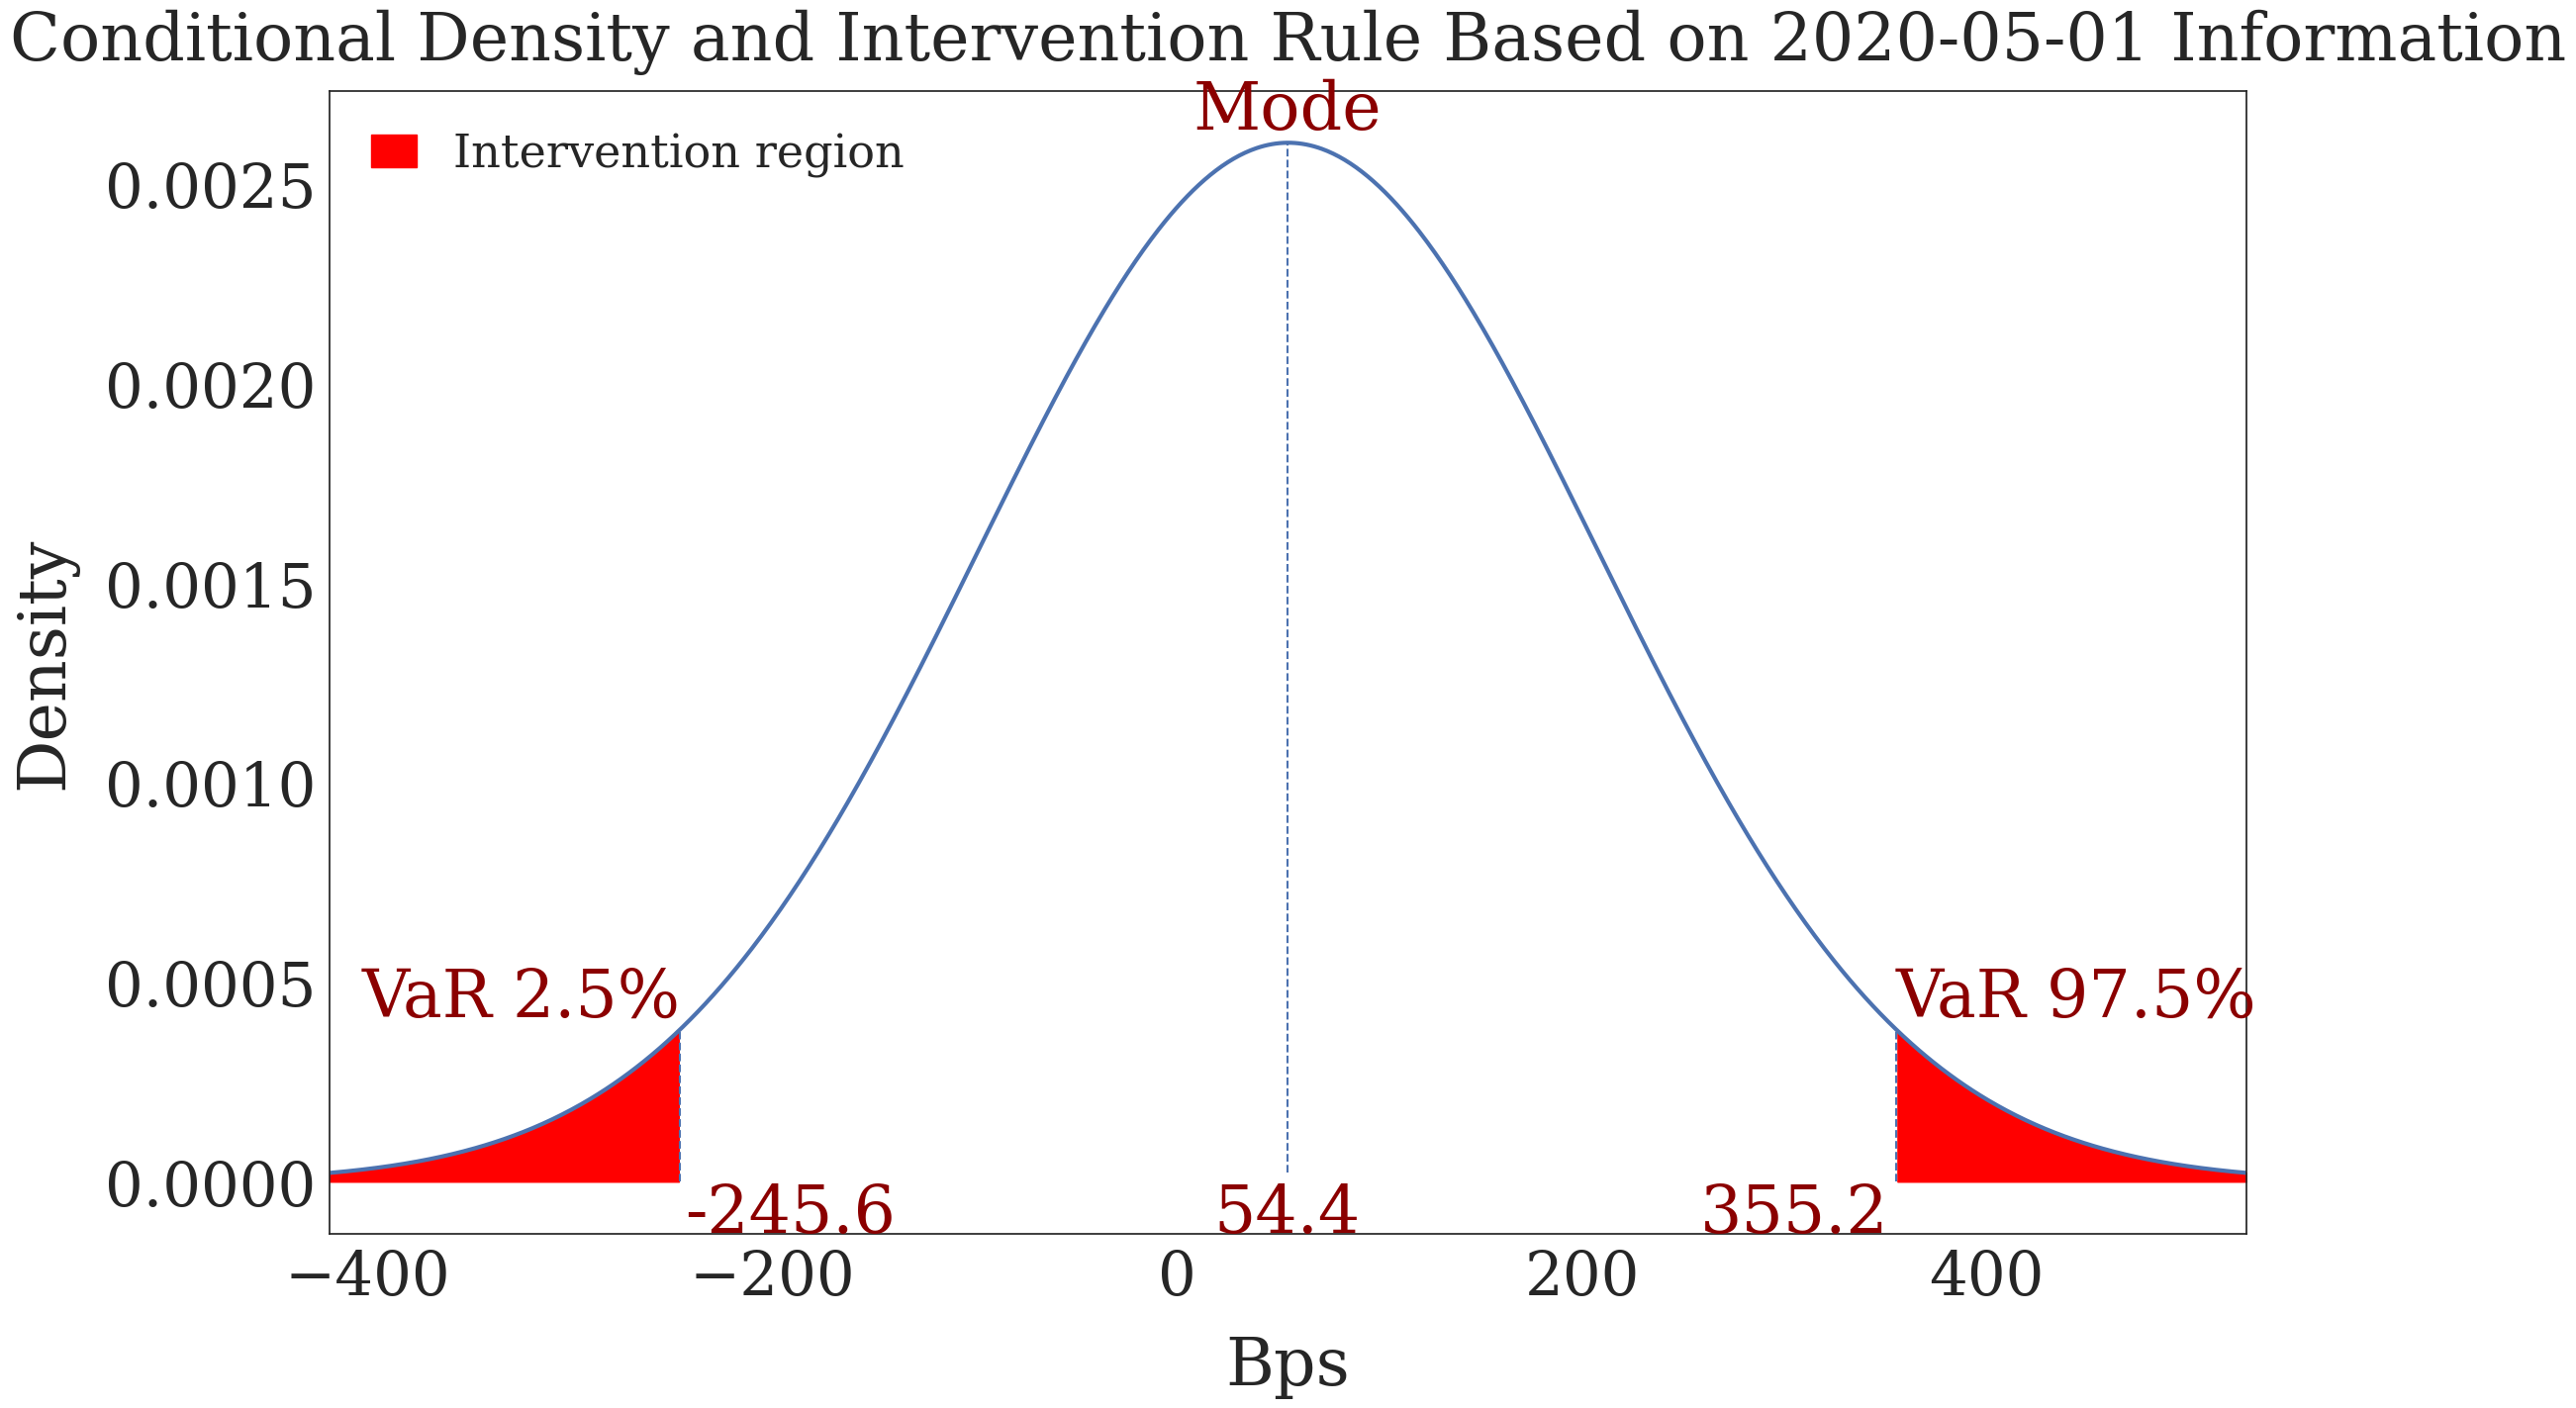

In [19]:
# Plot
dgfor.plot.plot_pdf_rule(fdate='2020-05-01', q_low=0.025, q_high=0.975, 
                    title='Conditional Density and Intervention Rule Based on 2020-05-01 Information', 
                    ylabel='Density', xlabel='Bps')

# Save the figure
var_rule_f = os.path.join(output_folder, 'var_rule.pdf')
plt.savefig(var_rule_f, bbox_inches='tight')
plt.show()
plt.close('all')

### Figure 8. Conditional CDF, Out-of-sample

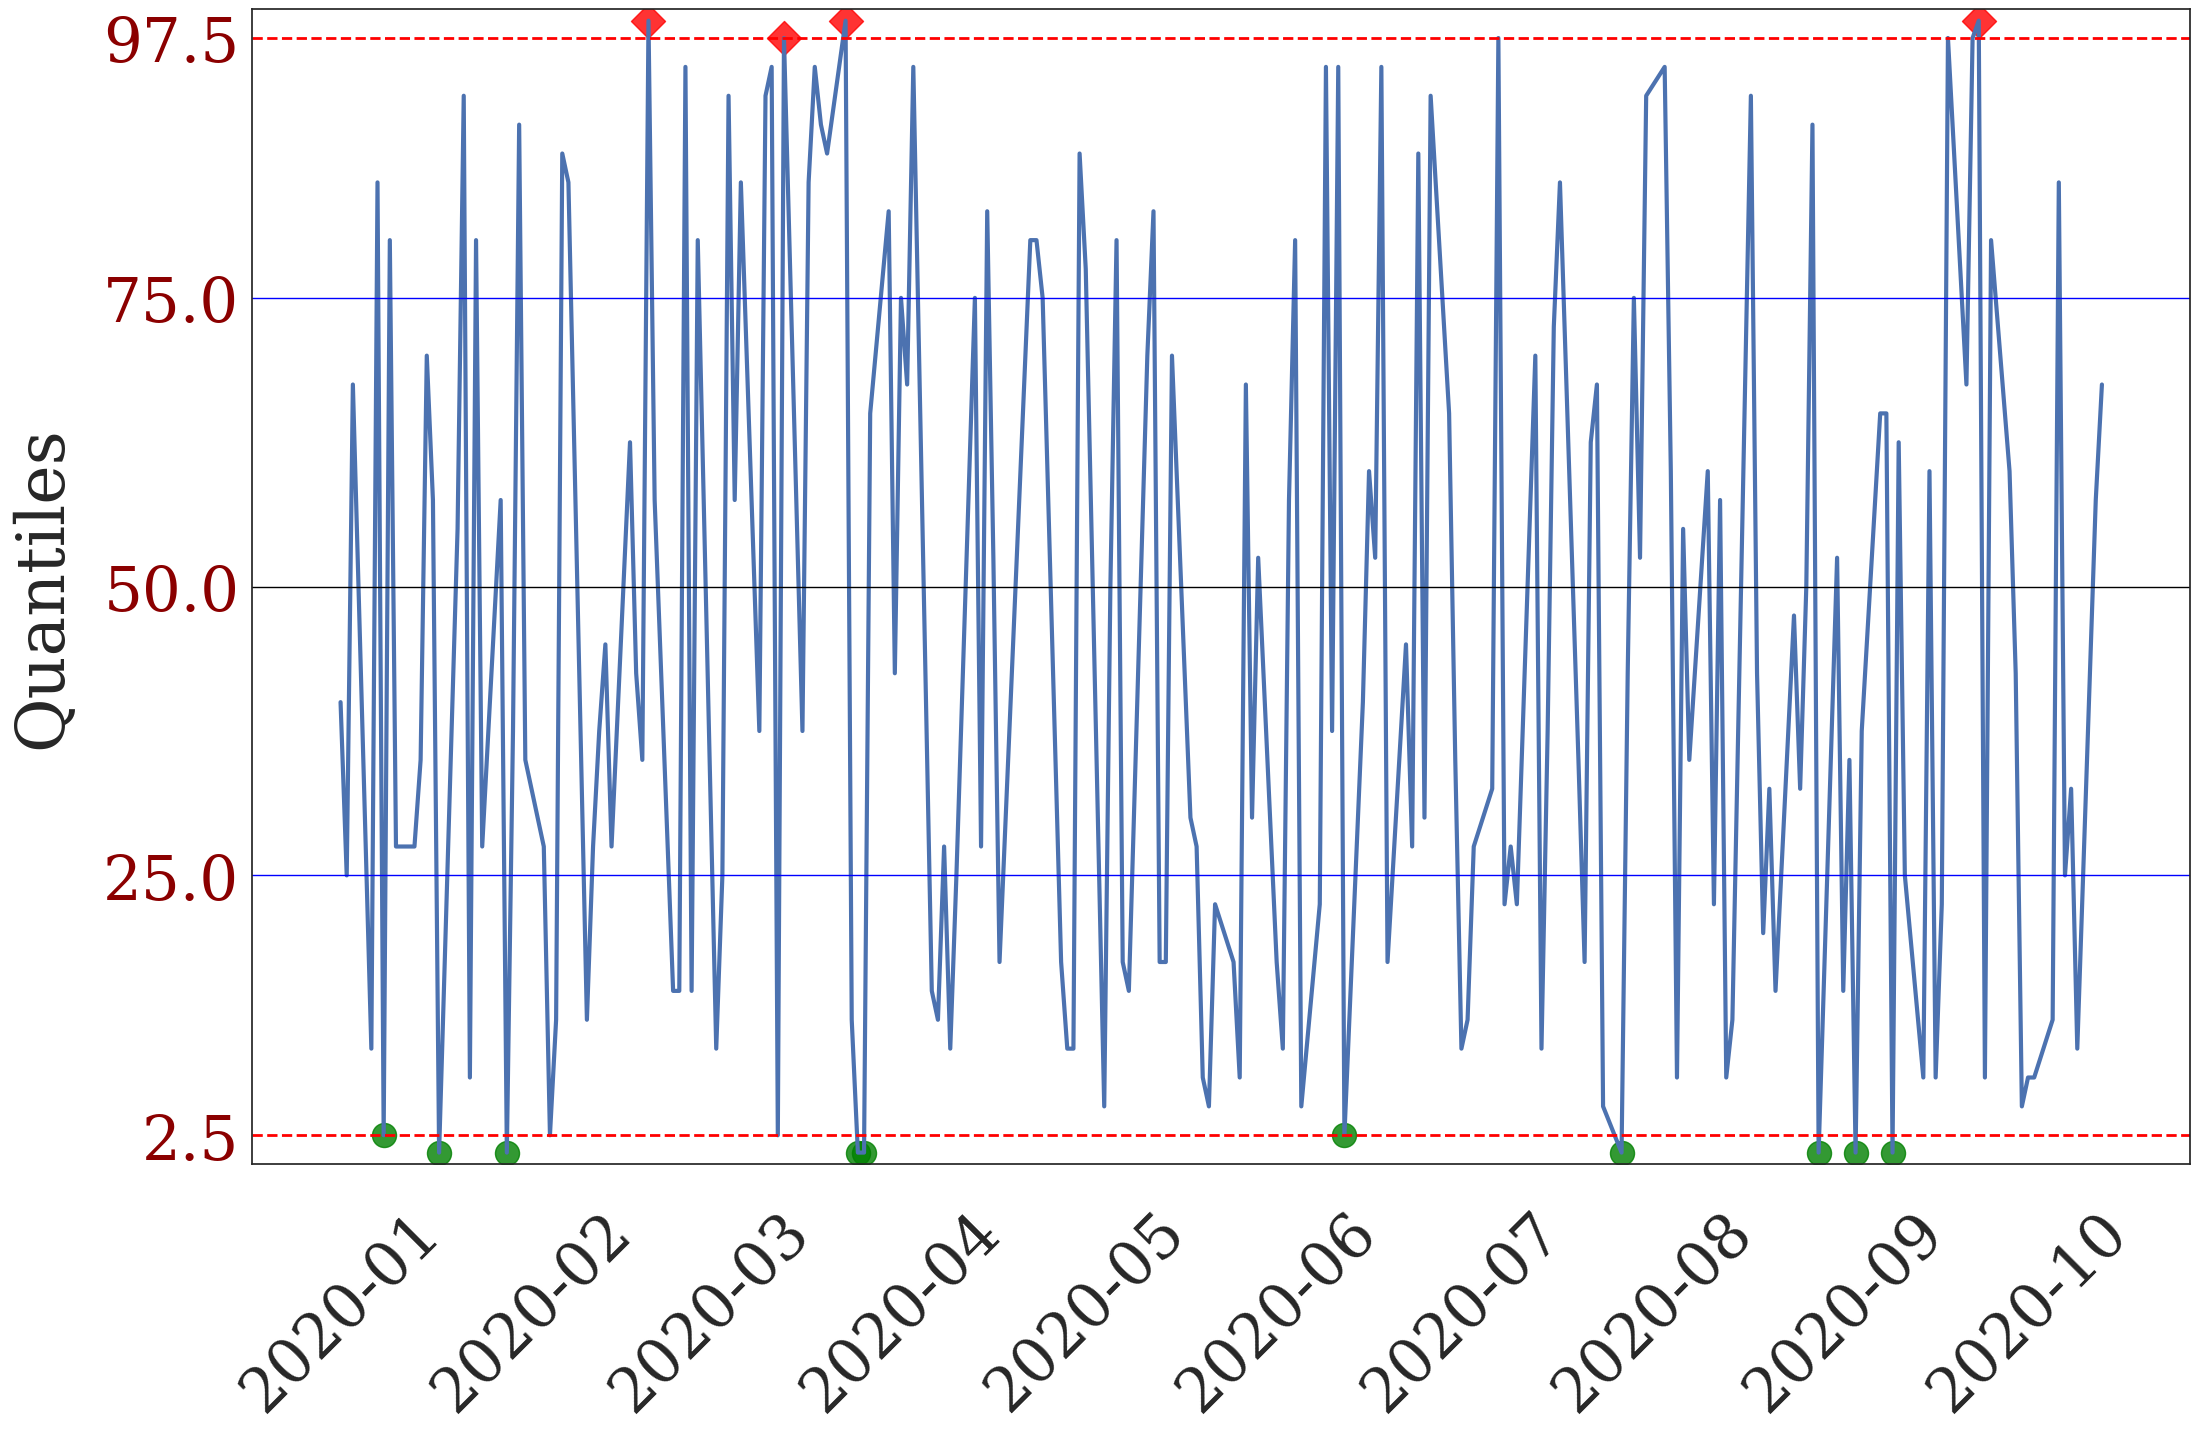

In [20]:
# Plot
dgfor.plot.plot_conditional_cdf(q_low=0.025, q_high=0.975, size=300, title='', ylabel='Quantiles')

# Save the figure
cond_cdf_f = os.path.join(output_folder, 'conditional_cdf.pdf')
plt.savefig(cond_cdf_f, bbox_inches='tight')
plt.show()
plt.close('all')

### Figure 9. Conditional VaR Exceedance, Out-of-Sample

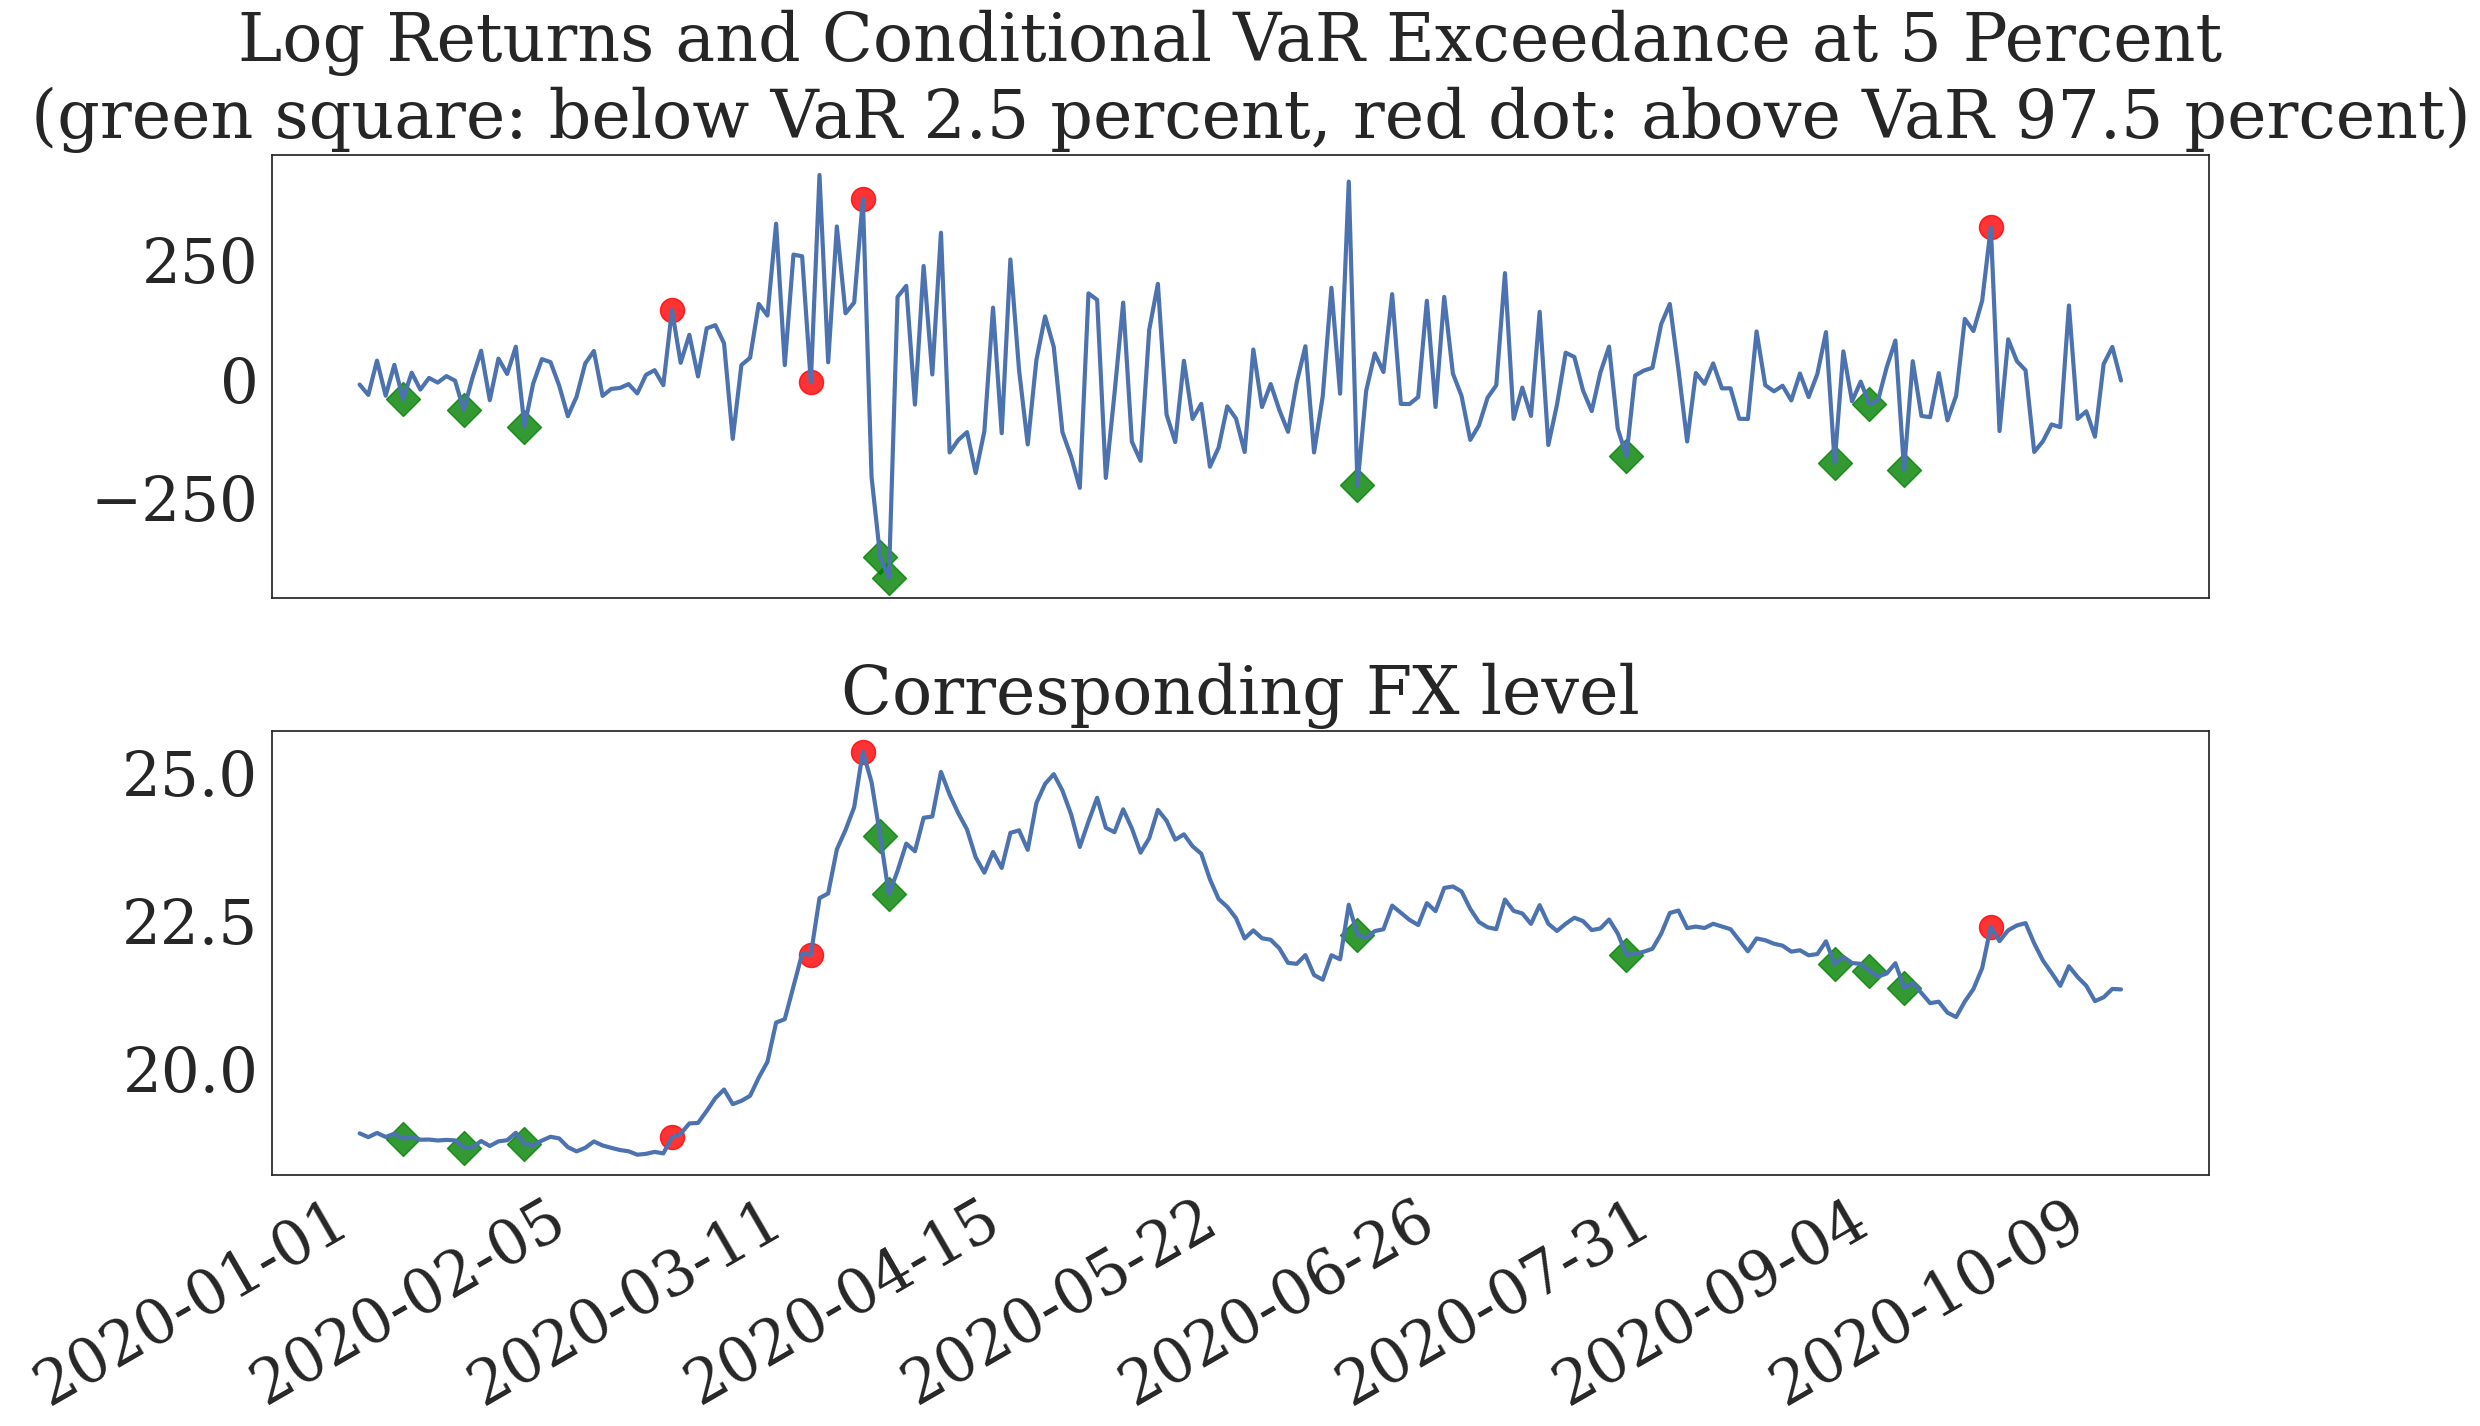

In [21]:
# Plot
dgfor.plot.plot_var_exceedance(qv_l=[0.025, 0.975], 
                          title_1= ('Log Returns and Conditional VaR Exceedance at 5 Percent'
                        ' \n (green square: below VaR 2.5 percent, red dot: above VaR 97.5 percent)'),
                          title_2='Corresponding FX level',
                          swap_color=True, size=300)

# Save the figure
cond_exc_f = os.path.join(output_folder, 'conditional_exceedance.pdf')
plt.savefig(cond_exc_f, bbox_inches='tight')
plt.show()
plt.close('all')

## Benchmarking exercise

In [22]:
# Forecast over the Banco Mexico intervention period for benchmarking
intervention_dates_l = df.loc[df['FX intervention dummy']==1, :].index
dgmfor = dgf.forecast(np.min(intervention_dates_l) - relativedelta(days=1), horizon=1)
dgmfor.compute_pit()

# Include the forecasted results within the original dataframe
dfxi = df.merge(dgmfor.dfor, left_index=True, right_index=True, how='outer')

# New variables
dfxi['FXI'] = (dfxi['sell_amount'] >0)
cond_fxi = (dfxi['FXI']==True)

dfxi['FXI current rate'] = np.nan
dfxi.loc[cond_fxi, 'FXI current rate'] = dfxi.loc[cond_fxi, 'FX level'].copy()

dfxi['FXI current logret'] = np.nan
dfxi.loc[cond_fxi,'FXI current logret'] = dfxi.loc[cond_fxi, 'FX log returns']

dfxi['FXI cdf'] = np.nan
dfxi.loc[cond_fxi, 'FXI cdf'] = dfxi.loc[cond_fxi, 'pit']

# Differentiate between intervention types
dmfxi = dfxi.loc[np.min(intervention_dates_l):np.max(intervention_dates_l), :].copy()
dfr = dmfxi.loc[dmfxi["type"]=='min price', :].copy() # Rule
dfd = dmfxi.loc[dmfxi["type"]=='no min price', :].copy() # Discretion


### Figure 10. Rule-based FX Interventions on the Mexican Peso/USD

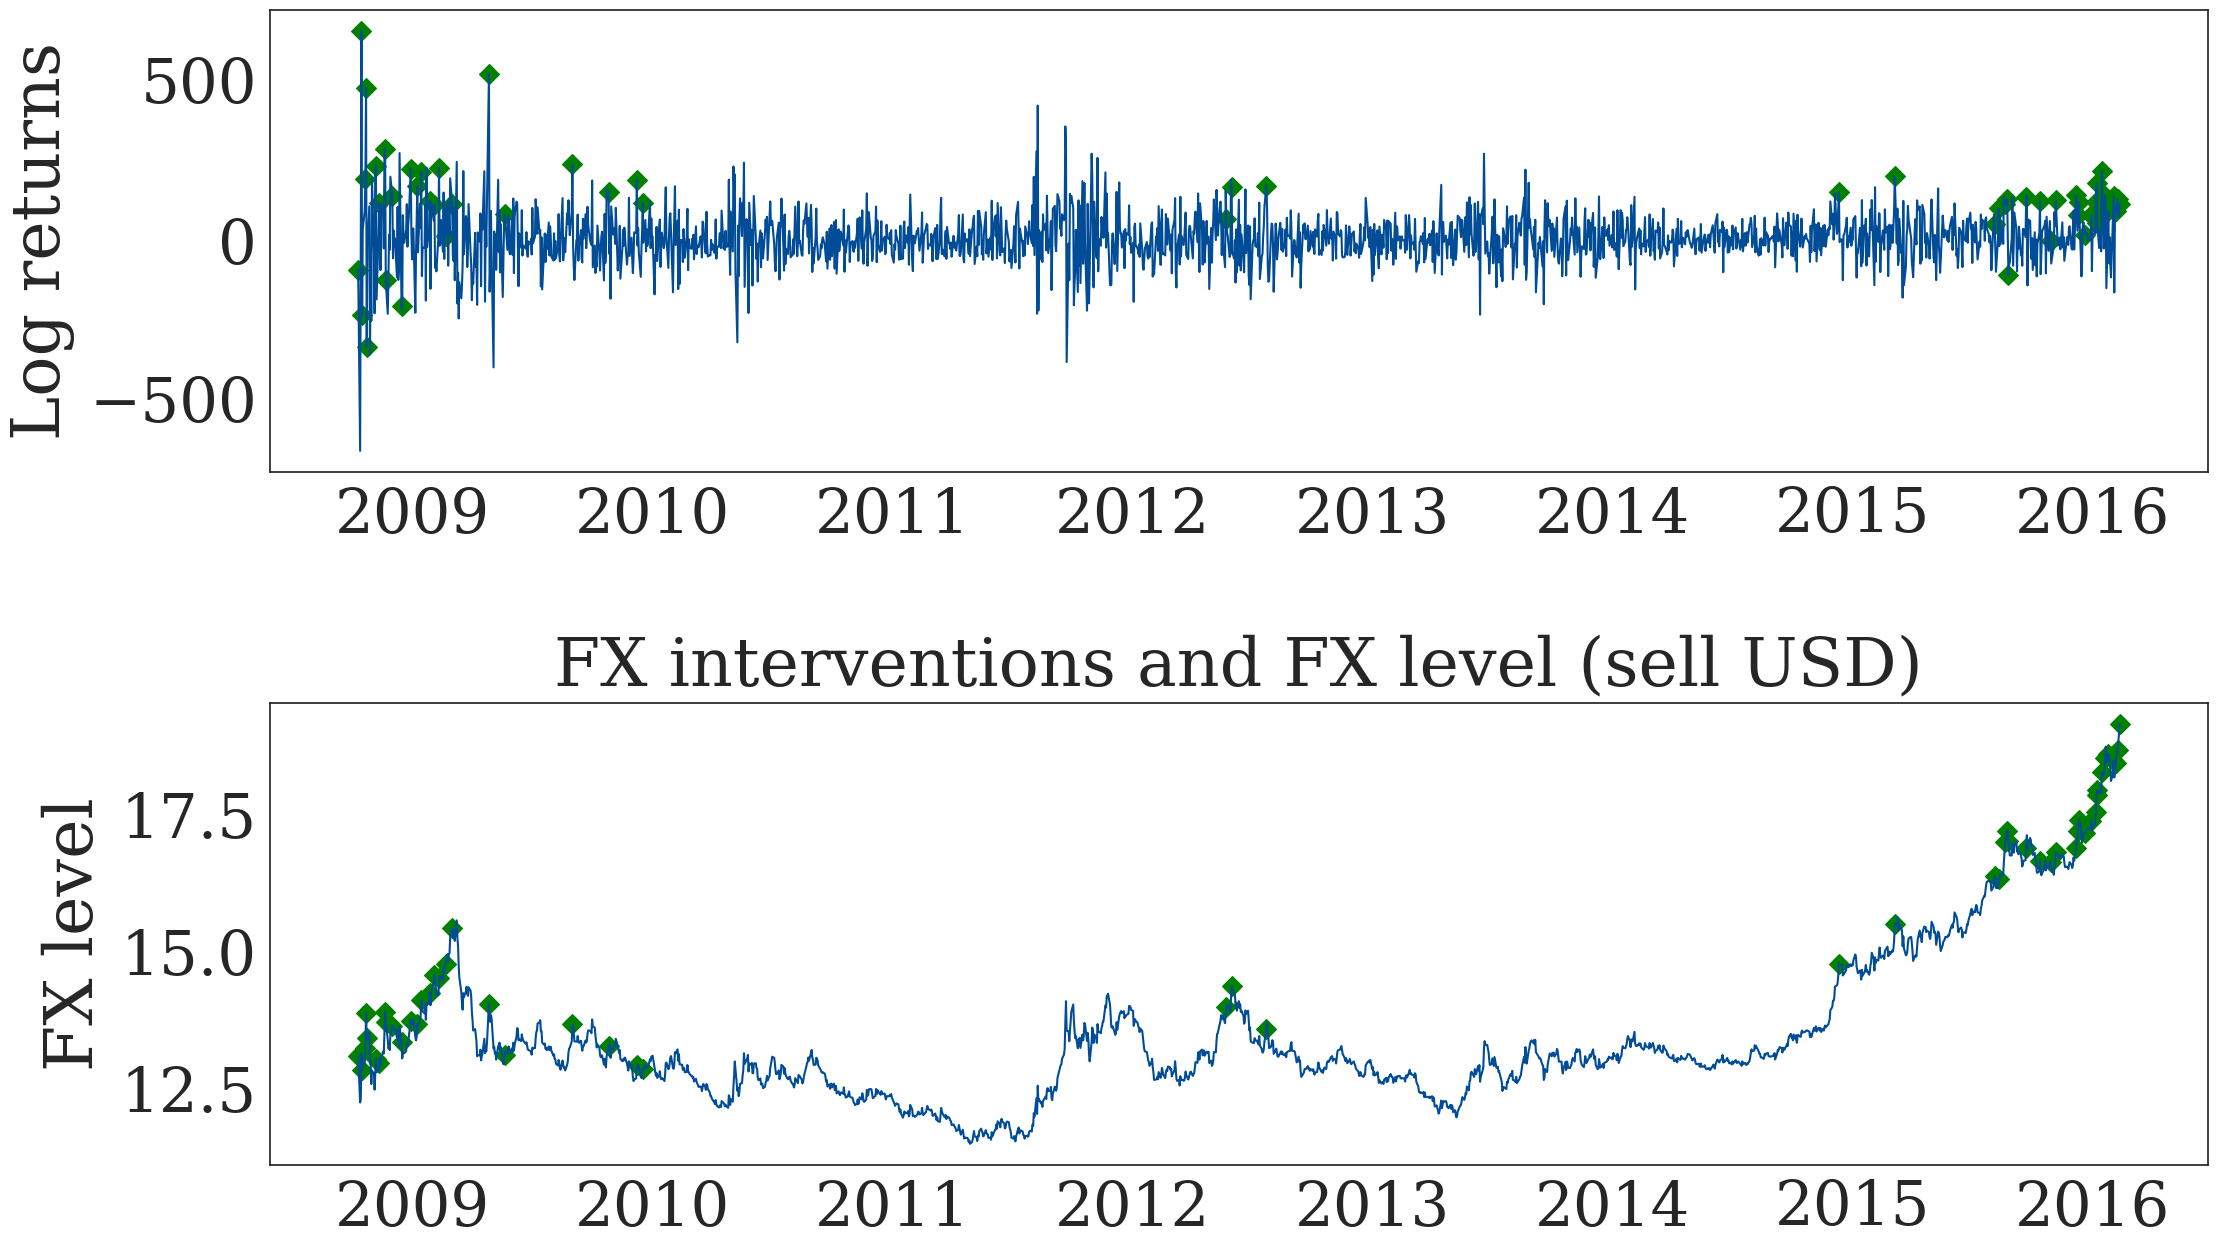

In [23]:
# With minimum price (== rule based)
# Plot
fig, (ax1, ax2) = plt.subplots(2,1)

# Log returns
ax1.plot(dmfxi.index, dmfxi['FX log returns'], color='#004C97')
ax1.scatter(dfr.index, dfr['FXI current logret'], s=100, color='green', marker='D')

ax1.set_title('',y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Log returns', labelpad=10)

# Level
ax2.plot(dmfxi.index, dmfxi['FX level'], color='#004C97')
ax2.scatter(dfr.index, dfr['FXI current rate'], s=100, color='green', marker='D')

ax2.set_title('FX interventions and FX level (sell USD)',
              y=1.02)
ax2.set_xlabel('')
ax2.set_ylabel('FX level', labelpad=10)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Save the figure
bench_minprice_f = os.path.join(output_folder, 'benchmark_minprice.pdf')
plt.savefig(bench_minprice_f, bbox_inches='tight')
plt.show()
plt.close('all')



### Figure 11. Conditional CDF and Rule-based FX Interventions

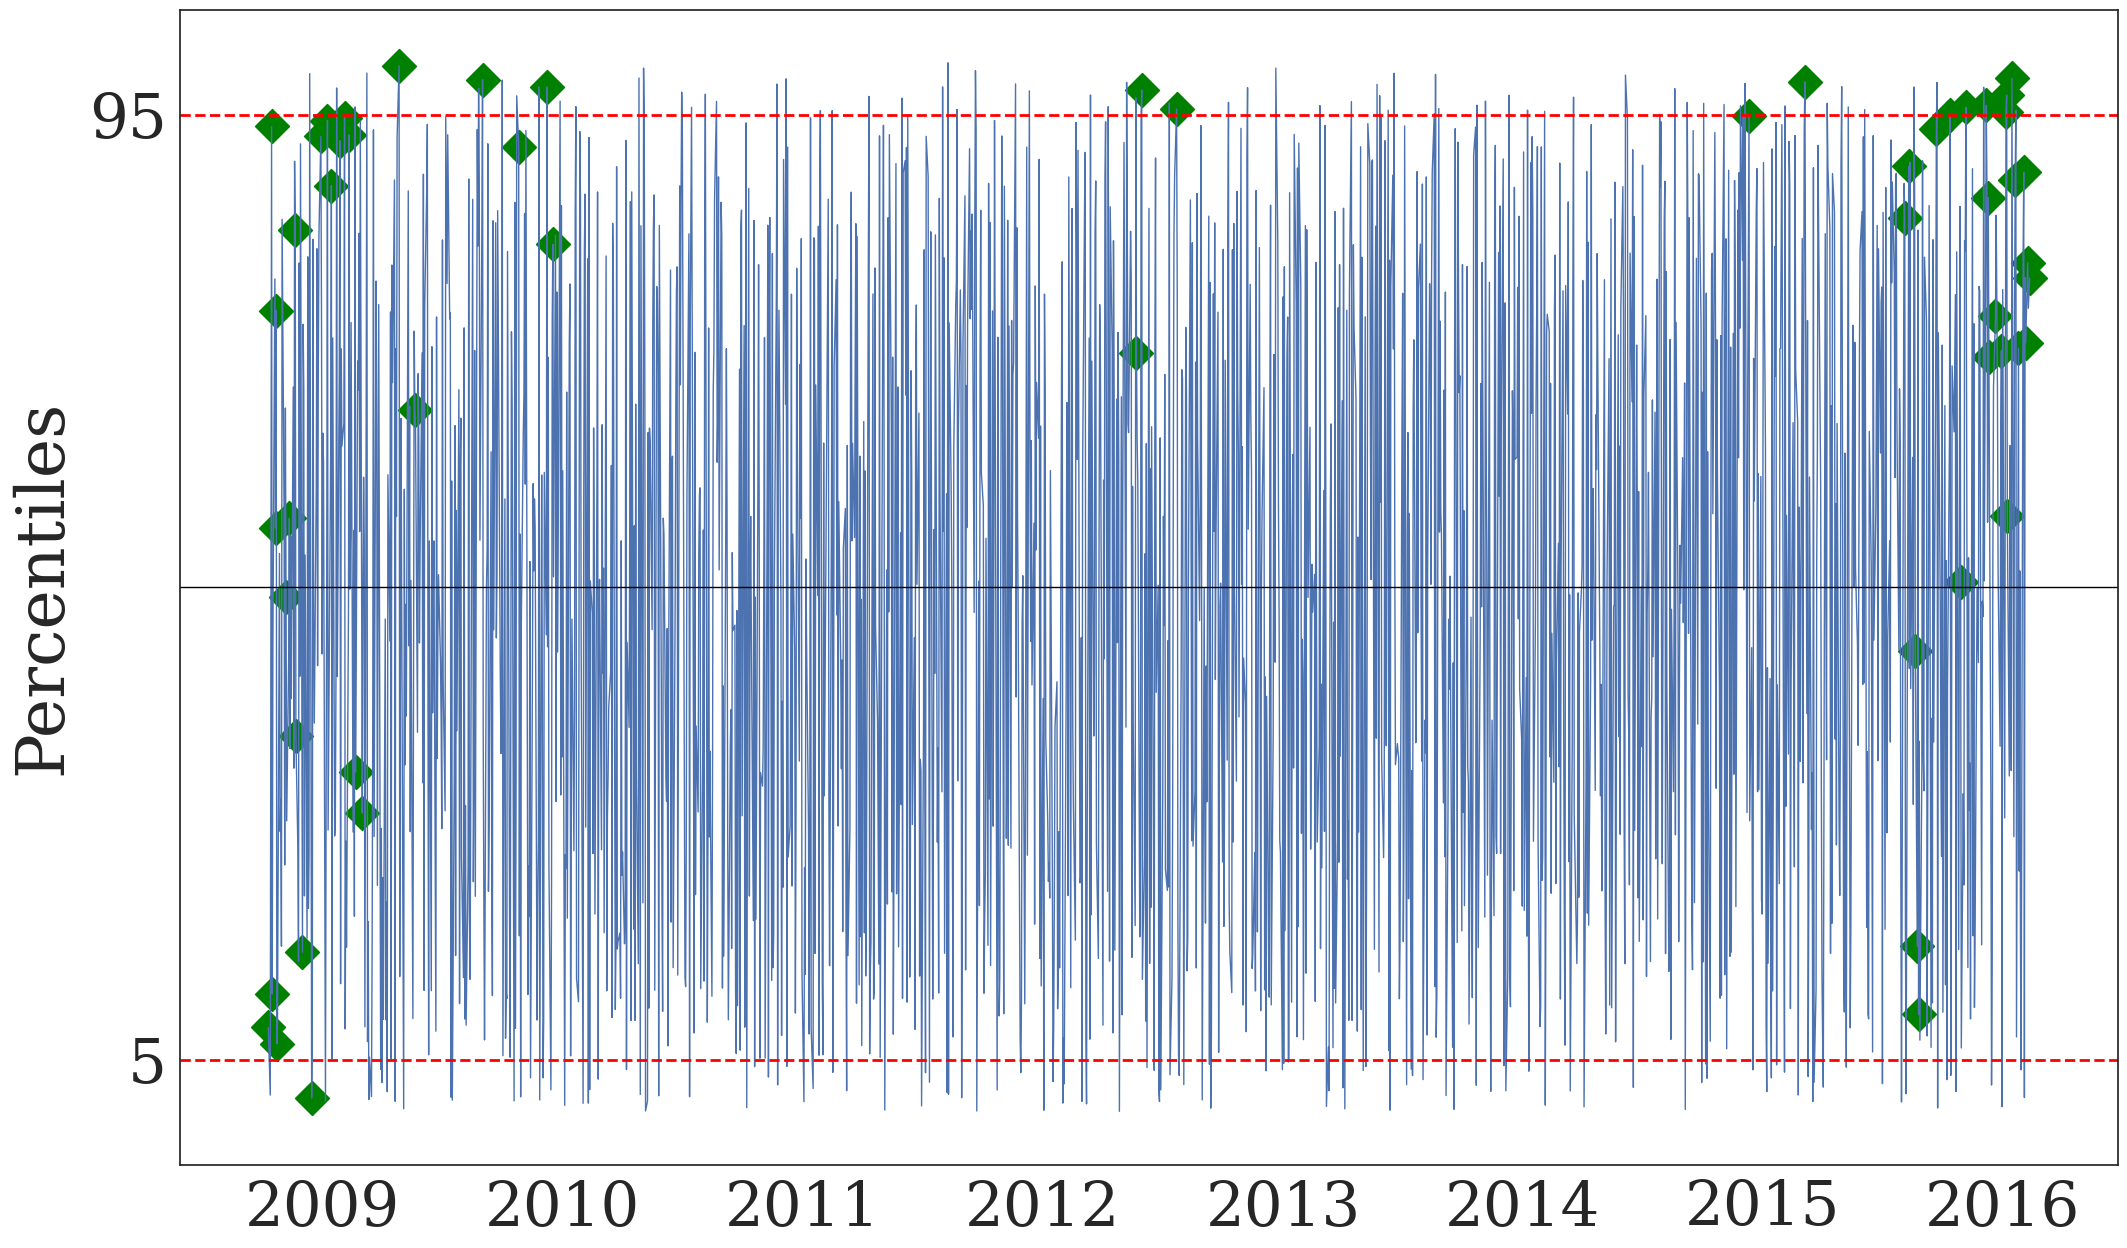

In [24]:
# PLot
fig, ax1 = plt.subplots(1,1)

# Local merge to have the same axis
dr = pd.merge(dmfxi['pit'], dfr['FXI cdf'], left_index=True, right_index=True, how='left')

# Level plot
ax1.plot(dr.index, 100*dr['pit'], lw=1)
ax1.scatter(dr.index, 100*dr['FXI cdf'], alpha=1, c='green', marker='D', s=300)
ax1.set_title('',
              y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Percentiles', labelpad=10)

ax1.axhline(y=5, color='red', linestyle='--', lw=2)
ax1.axhline(y=95, color='red', linestyle='--', lw=2)
ax1.axhline(y=50, color='black', linestyle='-', lw=1)

# Add the ticks, if needed
ax1.set_yticks([]) # Remove the standard y ticks
new_t_l = [5, 95]
new_ticks_l = sorted(list(ax1.get_yticks()) + new_t_l)
extra_idx_l = [new_ticks_l.index(x) for x in new_t_l]
ax1.set_yticks(new_ticks_l) # Add new ticks

ax1.set_ylim(-5, 105)

# Save the figure
bench_minprice_cdf_f = os.path.join(output_folder, 'benchmark_minprice_cdf.pdf')
plt.savefig(bench_minprice_cdf_f, bbox_inches='tight')
plt.show()
plt.close('all')



### Figure 12. Discretionary FX Interventions on the Mexican Peso/USD

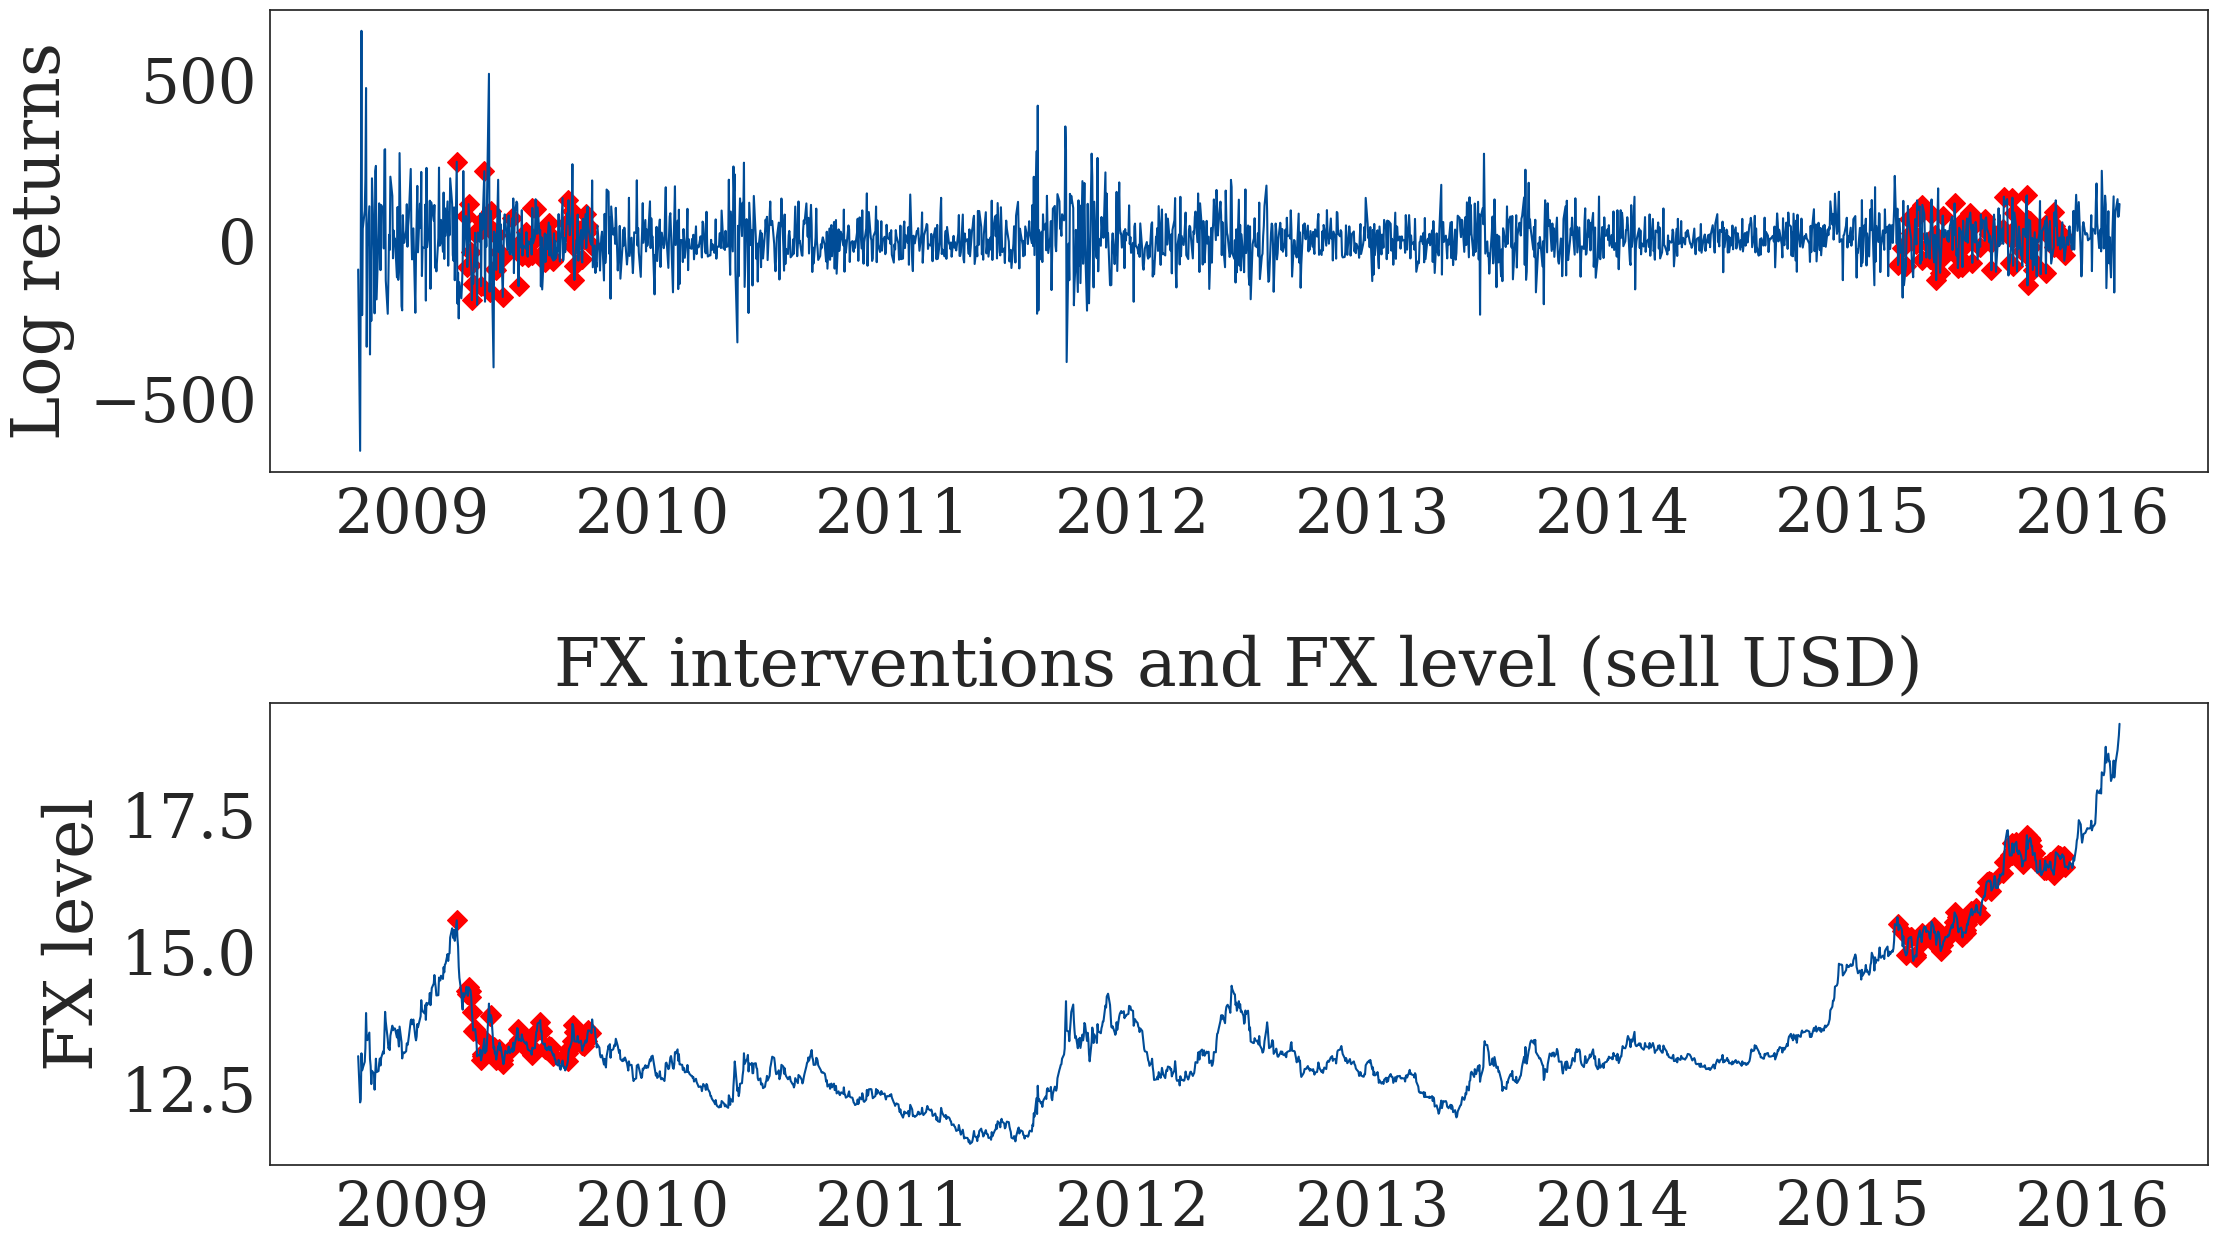

In [25]:
# Plot
fig, (ax1, ax2) = plt.subplots(2,1)

# Log returns
ax1.plot(dmfxi.index, dmfxi['FX log returns'], color='#004C97')
ax1.scatter(dfd.index, dfd['FXI current logret'],
            s=100, color='red',
            marker='D')

ax1.set_title('',
              y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Log returns', labelpad=10)

# Level
ax2.plot(dmfxi.index, dmfxi['FX level'], color='#004C97')
ax2.scatter(dfd.index, dfd['FXI current rate'], s=100, color='red',
            marker='D')

ax2.set_title('FX interventions and FX level (sell USD)',
              y=1.02)
ax2.set_xlabel('')
ax2.set_ylabel('FX level', labelpad=10)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Save the figure
bench_nominprice_f = os.path.join(output_folder, 'benchmark_no_minprice.pdf')
plt.savefig(bench_nominprice_f, bbox_inches='tight')
plt.show()
plt.close('all')



### Figure 13. Conditional CDF and Discretionary FX Interventions

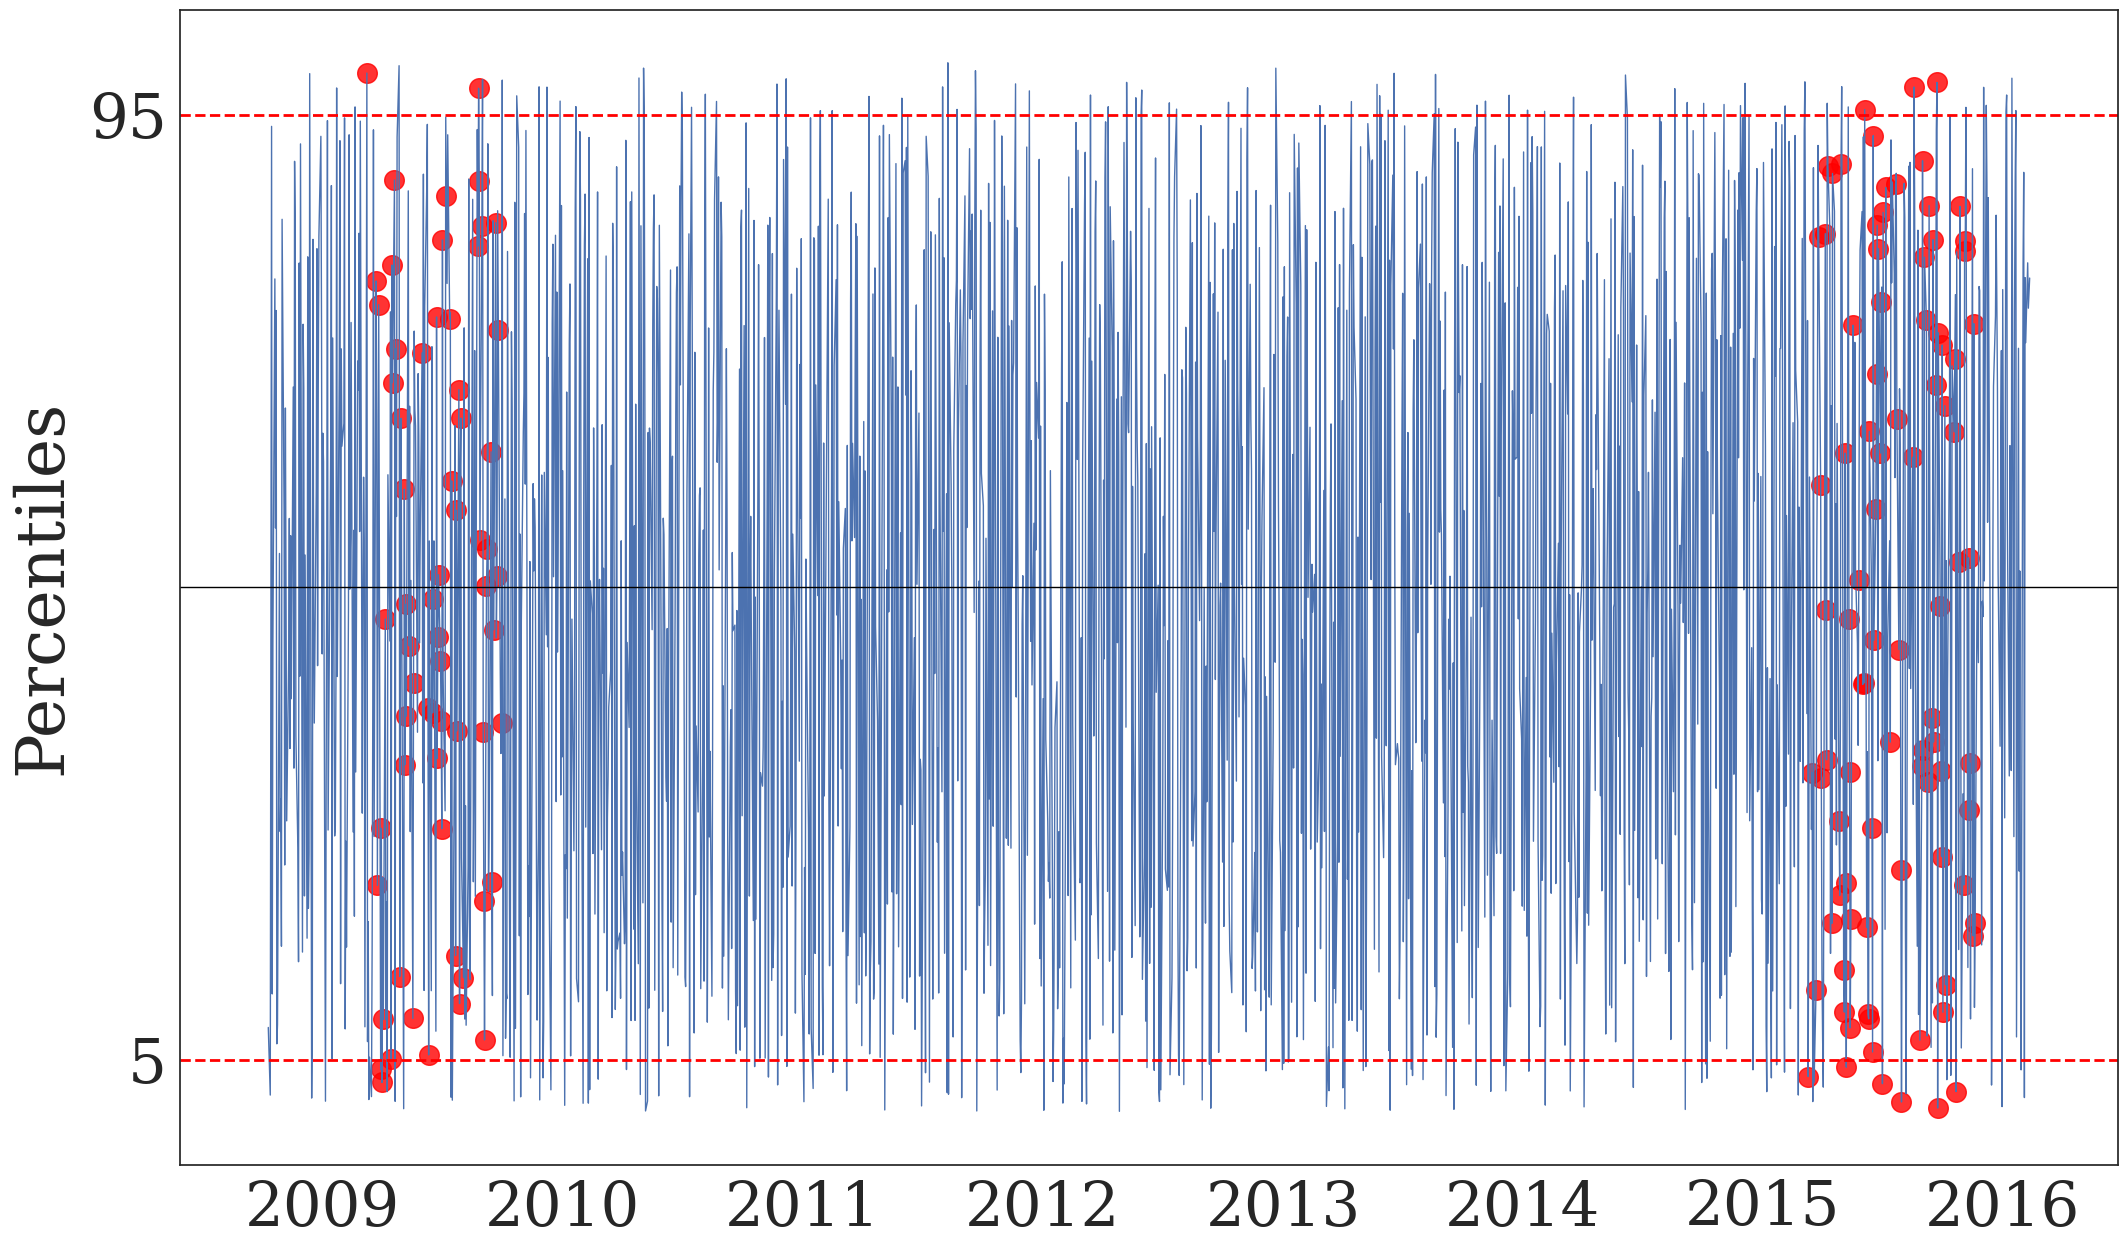

In [26]:
# Local merge to have the same axis
dd = pd.merge(dmfxi['pit'], dfd['FXI cdf'],
              left_index=True, right_index=True, how='left')

fig, ax1 = plt.subplots(1,1)
# Level plot
ax1.plot(dd.index, 100*dd['pit'], lw=1)
ax1.scatter(dd.index, 100*dd['FXI cdf'], alpha=0.8, c='red', marker='o', s=200)
ax1.set_title('', y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Percentiles', labelpad=10)

ax1.axhline(y=5, color='red', linestyle='--', lw=2)
ax1.axhline(y=95, color='red', linestyle='--', lw=2)
ax1.axhline(y=50, color='black', linestyle='-', lw=1)

# Add the ticks, if needed
ax1.set_yticks([]) # Remove the standard y ticks
new_t_l = [5, 95]
new_ticks_l = sorted(list(ax1.get_yticks()) + new_t_l)
extra_idx_l = [new_ticks_l.index(x) for x in new_t_l]
ax1.set_yticks(new_ticks_l) # Add new ticks

ax1.set_ylim(-5, 105)

# Save the figure
bench_no_minprice_cdf_f = os.path.join(output_folder, 'benchmark_no_minprice_cdf.pdf')
plt.savefig(bench_no_minprice_cdf_f, bbox_inches='tight')
plt.show()
plt.close('all')



### Optimize Model

In [27]:
dgo  = dg.optimize()

In [28]:
mean_optim = dgo.optimize_mean()

Optimizing the Mean model. step 1: exog_l


100%|██████████| 255/255 [00:21<00:00, 11.97it/s]


Best Out-Of-Sample combination of exogenous variables: 
Bid ask abs,Forward points first difference,EURUSD log returns,VIX first diff,Oil prices log returns,FX intervention dummy lag
Optimizing the Mean model. step 2: number of lags


100%|██████████| 10/10 [00:00<00:00, 11.14it/s]


Best Out-Of-Sample number of lags: 0


In [29]:
vol_dist_optimization = dgo.optimize_vol_distrib()
vol_dist_optimization

100%|██████████| 28/28 [03:17<00:00,  7.04s/it]

Best Out-Of-Sample Volatility Model: RiskMetric
Best Out-Of-Sample Distribution Family: SkewStudent


KS_normalized_innovations  \
volatility_model distribution                                 
Constant         Normal                               False   
ARCH             Normal                               False   
RiskMetric       Normal                               False   
GARCH            Normal                               False   
GJR-GARCH        Normal                               False   
EGARCH           Normal                               False   
EWMA             Normal                               False   
RiskMetric       StudentT                             False   
GJR-GARCH        SkewStudent                          False   
EGARCH           SkewStudent                          False   
GARCH            StudentT                             False   
GJR-GARCH        StudentT                             False   
EGARCH           StudentT                             False   
EWMA             StudentT                             False   
RiskMetric       GeneralizedError                     False   
ARCH             SkewStudent                          False   
GARCH            GeneralizedError                     False   
ARCH             StudentT                             False   
GJR-GARCH        GeneralizedError                     False   
EGARCH           GeneralizedError                     False   
EWMA             GeneralizedError                     False   
Constant         StudentT                             False   
ARCH             GeneralizedError                     False   
Constant         GeneralizedError                     False   
RiskMetric       SkewStudent                           True   
GARCH            SkewStudent                           True   
EWMA             SkewStudent                           True   
Constant         SkewStudent                           True   

                                  KS_normalized_innovations_pvalues  \
volatility_model distribution                                         
Constant         Normal                                         0.0   
ARCH             Normal                                         0.0   
RiskMetric       Normal                                    0.000547   
GARCH            Normal                                    0.000742   
GJR-GARCH        Normal                                    0.005783   
EGARCH           Normal                                    0.000092   
EWMA             Normal                                    0.024125   
RiskMetric       StudentT                                  0.010851   
GJR-GARCH        SkewStudent                               0.039789   
EGARCH           SkewStudent                               0.026603   
GARCH            StudentT                                  0.012535   
GJR-GARCH        StudentT                                  0.011123   
EGARCH           StudentT                                  0.008192   
EWMA             StudentT                                  0.004003   
RiskMetric       GeneralizedError                          0.000802   
ARCH             SkewStudent                                    0.0   
GARCH            GeneralizedError                          0.002497   
ARCH             StudentT                                       0.0   
GJR-GARCH        GeneralizedError                          0.002383   
EGARCH           GeneralizedError                          0.000739   
EWMA             GeneralizedError                          0.000058   
Constant         StudentT                                   0.02714   
ARCH             GeneralizedError                               0.0   
Constant         GeneralizedError                           0.00069   
RiskMetric       SkewStudent                               0.175627   
GARCH            SkewStudent                               0.207382   
EWMA             SkewStudent                               0.154791   
Constant         SkewStudent                               0.954117   

            

In [30]:
params_finetuning = dgo.fine_tune_model()
params_finetuning

Fine Tune the best model
exog_l = ['Bid ask abs', 'Forward points first difference', 'EURUSD log returns', 'VIX first diff', 'Oil prices log returns', 'FX intervention dummy lag']
lags = 0
volatility model = RiskMetric
distribution family = SkewStudent
Stabilize Parameters with ZigZag method ...
Converged !


iteration_0               iteration_1  \
                                     params       pvalues      params   
Const                             -1.216365  2.309328e-01   -0.607584   
Bid ask abs                      179.577584  1.419435e-03  130.946085   
Forward points first difference   29.503987  4.509421e-11   25.199999   
EURUSD log returns                -0.216986  6.049060e-35   -0.160931   
VIX first diff                    16.435769  2.246135e-62   16.174239   
Oil prices log returns            -0.021753  9.899393e-06   -0.022793   
FX intervention dummy lag         -7.435743  1.756491e-01    2.039140   
eta                                8.396661  8.149240e-27    8.324480   
lambda                             0.097658  1.369063e-07    0.101543   

                                               iteration_2                 \
                                       pvalues      params        pvalues   
Const                             4.481975e-01   -0.608573   4.475783e-01   
Bid ask abs                       2.341489e-03  133.040555   2.061630e-03   
Forward points first difference   2.574928e-24   24.954502   1.246611e-23   
EURUSD log returns                1.556255e-30   -0.152832   6.030364e-28   
VIX first diff                   2.540096e-133   16.057678  1.592706e-135   
Oil prices log returns            2.262161e-11   -0.022642   2.016052e-11   
FX intervention dummy lag         6.738948e-01    1.754372   7.209052e-01   
eta                               2.356683e-27    8.332597   2.653405e-27   
lambda                            7.398261e-08    0.102415   5.931720e-08   

                                iteration_3                 
                                     params        pvalues  
Const                             -0.607069   4.486395e-01  
Bid ask abs                      133.283738   2.026134e-03  
Forward points first difference   24.939480   1.451601e-23  
EURUSD log returns                -0.151594   1.419340e-27  
VIX first diff                    16.032580  5.843260e-136  
Oil prices log returns            -0.022590   2.084256e-11  
FX intervention dummy lag          1.741334   7.228677e-01  
eta                                8.334466   2.729595e-27  
lambda                             0.102566   5.474931e-08

Model is fixed and won't be fitted again. The parameter provided will be used
                           AR-X - RiskMetrics2006 Model Results                          
Dep. Variable:                    FX log returns   R-squared:                          --
Mean Model:                                 AR-X   Adj. R-squared:                     --
Vol Model:                       RiskMetrics2006   Log-Likelihood:               -30537.2
Distribution:      Standardized Skew Student's t   AIC:                           61092.4
Method:                User-specified Parameters   BIC:                           61152.2
                                                   No. Observations:                 5681
Date:                           Sat, Apr 15 2023                                         
Time:                                   10:18:55                                         
                Mean Model                
                                      coef
--------------------------

<Axes: title={'center': 'Conditional density and intervention rule based on 2020-10-14 information'}, xlabel='bps', ylabel='density'>

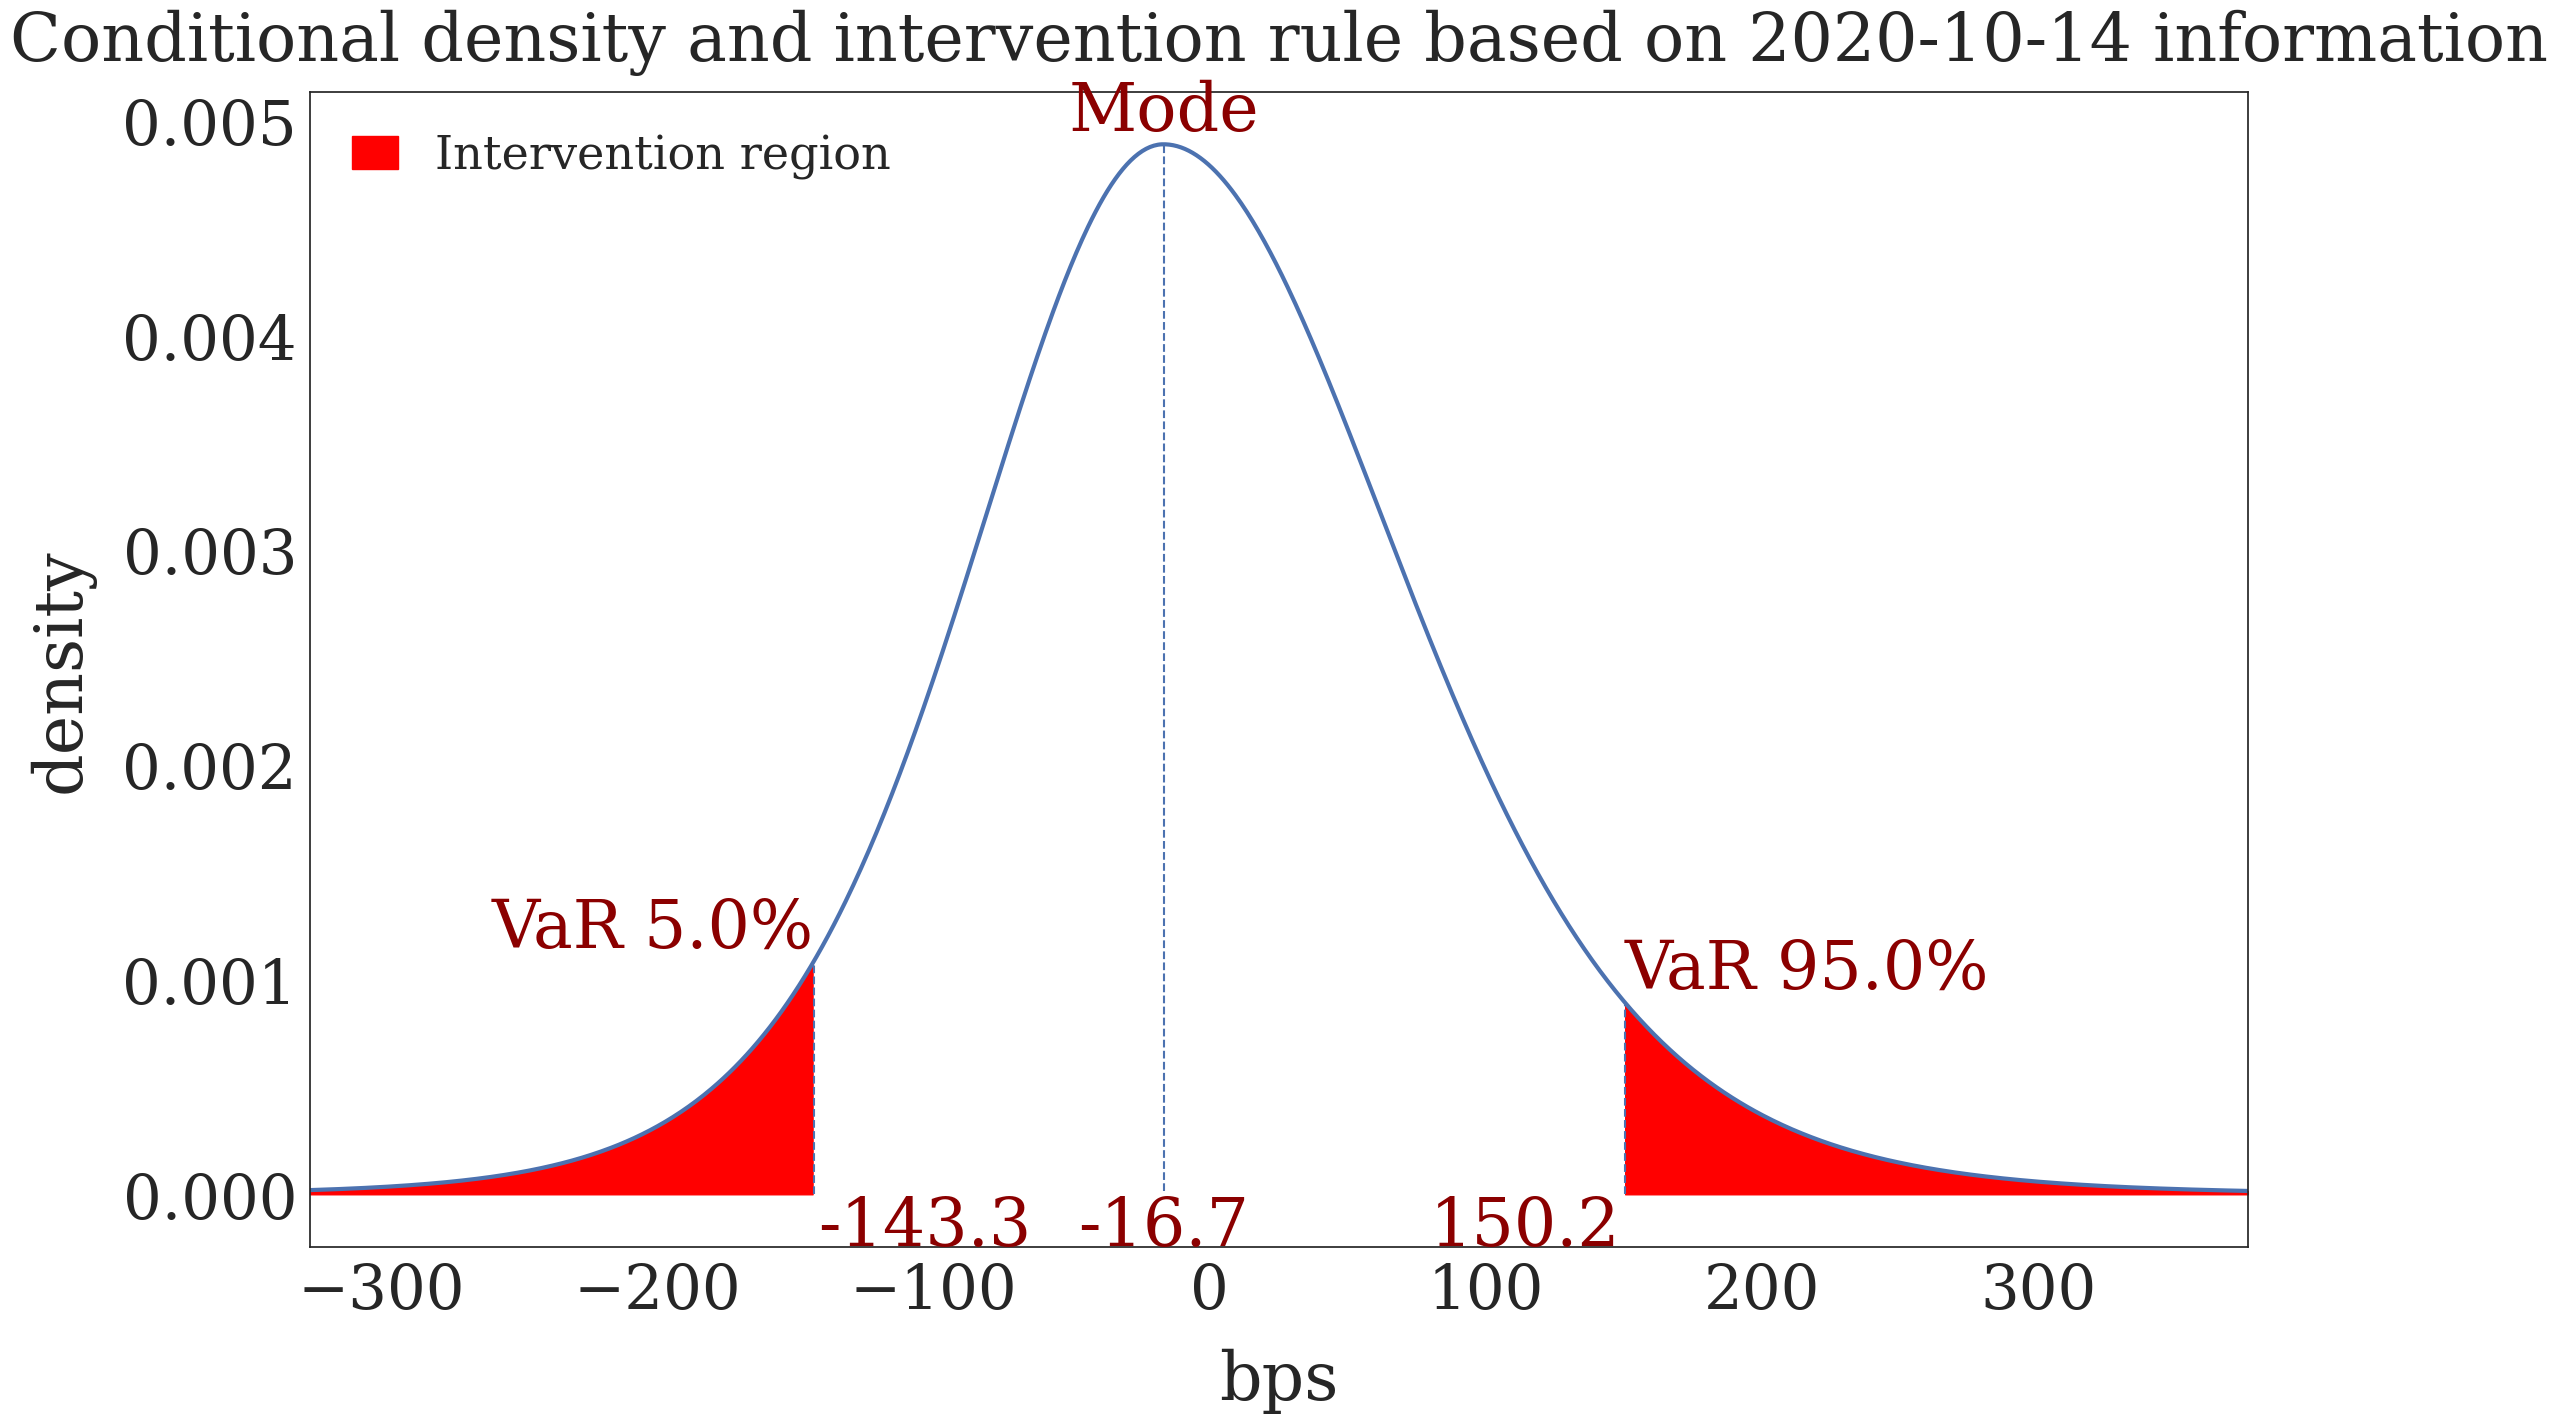

In [31]:
final_forecaster = dgo.final_model.forecast()
final_forecaster.plot.plot_pdf_rule()